![Python](https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54)
![Badge en Desarollo](https://img.shields.io/badge/STATUS-In%20development-green) 
![Last Update](https://img.shields.io/badge/Last_Update-May_2025-blue) 

# CNN PLATO

Latest version of the Convolutional Neural Network development notebook for ESA's PLATO mission.

The starting point of this development is: CNN_PLATO_v1.0 where we can summarise the following content:

1. **Import** of the necessary modules
2. **Import** of the pre-processed images.
3. **Definition of the initial neural network model**. From v1.0 we obtain the initial architecture in order to improve it. The following considerations are made: 
- The images are not normalised 
- To train the model we use the images of the models: EM, FM3, FM6, FM10, FM16, FM20.
- To check the correct functioning of the model, FM22 is used.
4. **Training**.
Each set of images is divided into train, valid and test.
5. **Predictions** 

In [204]:
#import os
#import sys
#import numpy as np
#import random
#import pickle
#import numpy as np
#import tensorflow as tf
#import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split
#from tensorflow.keras import layers, models

In [205]:
# Set seed for reproducibility
import numpy as np
import random

seed = 13
np.random.seed(seed)
random.seed(seed)

In [206]:
# Add the src directory to sys.path
import sys
import os
src_path = os.path.abspath('../')
sys.path.append(src_path)

try:
    # Combine src_path with PREPROCESSED_IMAGES_DIR to get the full path
    full_preprocessed_images_dir = os.path.abspath(os.path.join(src_path, 'data/processed'))
    print("Preprocess images path loaded successfully.")
except ImportError as e:
    print(f"Error importing PREPROCESSED_IMAGES_DIR: {e}")
    
PREPROCESSED_IMAGES_DIR=full_preprocessed_images_dir

Preprocess images path loaded successfully.


## 1. Load and split data

model: ["EM", "FM3", "FM6", "FM10", "FM16", "FM20", "FM22"]

image_type: ["Plateaux", "BFT"]


In [207]:
import os
import numpy as np
import pickle

# 1. Load and Filter Data
def load_and_filter_data(file_path):
    """
    Loads and filters data from a pickle file.

    Args:
        file_path (str): Path to the pickle file.

    Returns:
        list: Filtered list of dictionaries.
    """
    with open(file_path, 'rb') as file:
        dictionaries = pickle.load(file)
    
    # Create a set to store unique obsid values
    unique_obsids = set(dictionary['obsid'] for dictionary in dictionaries)

    # List to store the filtered dictionaries
    filtered_dictionaries = []

    # Iterate over each unique obsid
    for obsid in unique_obsids:
        # Filter dictionaries with the same obsid
        same_obsid_dictionaries = [dictionary for dictionary in dictionaries if dictionary['obsid'] == obsid]

        # Iterate over dictionaries with the same obsid
        for dictionary in same_obsid_dictionaries:
            # Handle both 'fov_numero' and 'fov_number'
            fov_key = 'fov_numero' if 'fov_numero' in dictionary else 'fov_number' if 'fov_number' in dictionary else None
            
            # Skip if neither key is present
            if fov_key is None:
                continue
            
            # Filter dictionaries where frame equals 1
            if not (dictionary['frame'] == 1 and dictionary[fov_key] == dictionary[fov_key]):
                filtered_dictionaries.append(dictionary)

    return filtered_dictionaries

# 2. Process Data by Model and Image Type
def process_data_by_model_and_type(models, image_types, preprocessed_images_dir):
    """
    Processes data by model and image type, ensuring consistency in key names.

    Args:
        models (list): List of models to process.
        image_types (list): List of image types to process.
        preprocessed_images_dir (str): Directory containing preprocessed images.

    Returns:
        dict: Dictionary containing data organized by model and image type.
    """
    data_by_model = {}

    for model in models:
        data_by_model[model] = {'images': {}, 'temperature': {}, 'eef': {}}
        print(f"Model: {model}")  # Print the current model being processed

        for image_type in image_types:
            # Construct the file path
            file_name = f'images_{model}_{image_type}.pkl'
            file_path = os.path.join(preprocessed_images_dir, file_name)
            
            # Check if the file exists
            if os.path.exists(file_path):
                # Load and filter the data
                filtered_data = load_and_filter_data(file_path)
                
                # Normalize keys for consistency
                normalized_data = []
                for item in filtered_data:
                    normalized_item = {
                        'image': item.get('imagen_recortada', item.get('cropped_image')),
                        'temperature': item.get('Temperatura_TRP1', item.get('Temperature_TRP1')),
                        'eef': item.get('eef')
                    }
                    normalized_data.append(normalized_item)
                
                # Extract images, temperatures, and eef
                data_by_model[model]['images'][image_type.lower()] = np.array([
                    item['image'] for item in normalized_data if item['image'] is not None
                ])
                data_by_model[model]['temperature'][image_type.lower()] = np.array([
                    item['temperature'] for item in normalized_data if item['temperature'] is not None
                ])
                data_by_model[model]['eef'][image_type.lower()] = np.array([
                    item['eef'] for item in normalized_data if item['eef'] is not None
                ])
                
                # Print the number of images imported for this model and image type
                num_images = len(data_by_model[model]['images'][image_type.lower()])
                print(f"  Image Type: {image_type} - Number of Images: {num_images}")
            else:
                print(f"  Image Type: {image_type} - File not found!")

    return data_by_model

# 3a. Split Data by flight model
def split_by_flight_model(data_by_model, models, image_types, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15, random_state=1):
    """
    Processes the data for each model, combining all image types and splitting into train, valid, and test sets.

    Args:
        data_by_model (dict): Dictionary containing data organized by model and image type.
        models (list): List of models to process.
        image_types (list): List of image types to process.
        train_ratio (float): Proportion of data for training.
        valid_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.
        random_state (int): Seed for random splitting.

    Returns:
        dict: Dictionary containing the split data by model.
    """
    from sklearn.model_selection import train_test_split

    # Ensure the ratios sum to 1
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios must sum to 1."

    data_splits = {}

    for model in models:
        data_splits[model] = {}
        for image_type in image_types:
            # Combine data for the current model and image type
            images = data_by_model[model]['images'].get(image_type.lower(), [])
            temperatures = data_by_model[model]['temperature'].get(image_type.lower(), [])
            eef = data_by_model[model]['eef'].get(image_type.lower(), [])

            if len(images) == 0 or len(temperatures) == 0 or len(eef) == 0:
                print(f"No data to split for model {model}, image type {image_type}.")
                continue

            # Calculate the size of the validation and test sets
            valid_test_ratio = valid_ratio + test_ratio
            valid_size = valid_ratio / valid_test_ratio

            # Split the data into train and temporary (validation + test) sets
            x_train, x_temp, temp_train, temp_temp, eef_train, eef_temp = train_test_split(
                images, temperatures, eef, test_size=valid_test_ratio, random_state=random_state
            )

            # Split the temporary set into validation and test sets
            x_valid, x_test, temp_valid, temp_test, eef_valid, eef_test = train_test_split(
                x_temp, temp_temp, eef_temp, test_size=valid_size, random_state=random_state
            )

            # Store the splits in the result dictionary
            data_splits[model][image_type] = {
                "image": {
                    "train": np.expand_dims(x_train, axis=-1),
                    "valid": np.expand_dims(x_valid, axis=-1),
                    "test": np.expand_dims(x_test, axis=-1),
                },
                "temperature": {
                    "train": temp_train,
                    "valid": temp_valid,
                    "test": temp_test,
                },
                "eef": {
                    "train": eef_train,
                    "valid": eef_valid,
                    "test": eef_test,
                },
            }

    return data_splits

# 3a. Split Data by image type
def split_by_image_types(data_by_model, models, image_types, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15, random_state=1):
    """
    Splits the data into two dictionaries: one for 'BFT' and one for 'Plateaux'.

    Args:
        data_by_model (dict): Dictionary containing data organized by model and image type.
        models (list): List of models to process.
        image_types (list): List of image types to process.
        train_ratio (float): Proportion of data for training.
        valid_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.
        random_state (int): Seed for random splitting.

    Returns:
        tuple: Two dictionaries, one for 'BFT' and one for 'Plateaux'.
    """
    from sklearn.model_selection import train_test_split

    # Ensure the ratios sum to 1
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios must sum to 1."

    # Initialize dictionaries for BFT and Plateaux
    data_bft = {"image": {"train": [], "valid": [], "test": []},
                "temperature": {"train": [], "valid": [], "test": []},
                "eef": {"train": [], "valid": [], "test": []}}

    data_plateaux = {"image": {"train": [], "valid": [], "test": []},
                     "temperature": {"train": [], "valid": [], "test": []},
                     "eef": {"train": [], "valid": [], "test": []}}

    for model in models:
        for image_type in image_types:
            # Combine data for the current model and image type
            images = data_by_model[model]['images'].get(image_type.lower(), [])
            temperatures = data_by_model[model]['temperature'].get(image_type.lower(), [])
            eef = data_by_model[model]['eef'].get(image_type.lower(), [])

            if len(images) == 0 or len(temperatures) == 0 or len(eef) == 0:
                print(f"No data to split for model {model}, image type {image_type}.")
                continue

            # Calculate the size of the validation and test sets
            valid_test_ratio = valid_ratio + test_ratio
            valid_size = valid_ratio / valid_test_ratio

            # Split the data into train and temporary (validation + test) sets
            x_train, x_temp, temp_train, temp_temp, eef_train, eef_temp = train_test_split(
                images, temperatures, eef, test_size=valid_test_ratio, random_state=random_state
            )

            # Split the temporary set into validation and test sets
            x_valid, x_test, temp_valid, temp_test, eef_valid, eef_test = train_test_split(
                x_temp, temp_temp, eef_temp, test_size=valid_size, random_state=random_state
            )

            # Store the splits in the appropriate dictionary
            target_dict = data_bft if image_type.lower() == "bft" else data_plateaux

            target_dict["image"]["train"].append(np.expand_dims(x_train, axis=-1))
            target_dict["image"]["valid"].append(np.expand_dims(x_valid, axis=-1))
            target_dict["image"]["test"].append(np.expand_dims(x_test, axis=-1))

            target_dict["temperature"]["train"].append(temp_train)
            target_dict["temperature"]["valid"].append(temp_valid)
            target_dict["temperature"]["test"].append(temp_test)

            target_dict["eef"]["train"].append(eef_train)
            target_dict["eef"]["valid"].append(eef_valid)
            target_dict["eef"]["test"].append(eef_test)

    # Concatenate the lists into numpy arrays
    for key in data_bft:
        for split in data_bft[key]:
            data_bft[key][split] = np.concatenate(data_bft[key][split], axis=0)

    for key in data_plateaux:
        for split in data_plateaux[key]:
            data_plateaux[key][split] = np.concatenate(data_plateaux[key][split], axis=0)

    return data_bft, data_plateaux

#4. Check data structure
def print_data_structure(data_splits):
    """
    Prints the structure of the split data by model and subtype.

    Args:
        data_splits (dict): Dictionary containing the split data by model and subtype.
    """
    for model, subtypes in data_splits.items():
        print(model + ":")
        for subtype, splits in subtypes.items():
            print("\t" + subtype + ":")
            for data_type, divisions in splits.items():
                print("\t\t" + data_type + ":")
                if isinstance(divisions, dict):  # Ensure divisions is a dictionary
                    for division, data in divisions.items():
                        print(f"\t\t\t{division} : {data.shape}")
                else:
                    print(f"\t\t\tUnexpected structure for {data_type}.")
     
#5. Check data consistency                    
def check_data_consistency_by_flight_model(data_splits):
    """
    Checks if the number of images matches the number of temperature and EEF labels
    for each model and subtype.

    Args:
        data_splits (dict): Dictionary containing the split data by model and subtype.

    Returns:
        bool: True if all data is consistent, False otherwise.
    """
    all_consistent = True

    for model, subtypes in data_splits.items():
        print(f"Checking consistency for model: {model}")
        for subtype, splits in subtypes.items():
            try:
                num_images_train = splits['image']['train'].shape[0]
                num_temperatures_train = splits['temperature']['train'].shape[0]
                num_eef_train = splits['eef']['train'].shape[0]

                num_images_valid = splits['image']['valid'].shape[0]
                num_temperatures_valid = splits['temperature']['valid'].shape[0]
                num_eef_valid = splits['eef']['valid'].shape[0]

                num_images_test = splits['image']['test'].shape[0]
                num_temperatures_test = splits['temperature']['test'].shape[0]
                num_eef_test = splits['eef']['test'].shape[0]

                if (
                    num_images_train == num_temperatures_train == num_eef_train and
                    num_images_valid == num_temperatures_valid == num_eef_valid and
                    num_images_test == num_temperatures_test == num_eef_test
                ):
                    print(f"\tSubtype: {subtype} - OK")
                else:
                    print(f"\tSubtype: {subtype} - Mismatch!")
                    print(f"\t\tTrain: Images={num_images_train}, Temperatures={num_temperatures_train}, EEF={num_eef_train}")
                    print(f"\t\tValid: Images={num_images_valid}, Temperatures={num_temperatures_valid}, EEF={num_eef_valid}")
                    print(f"\t\tTest: Images={num_images_test}, Temperatures={num_temperatures_test}, EEF={num_eef_test}")
                    all_consistent = False
            except KeyError as e:
                print(f"\tSubtype: {subtype} - Missing data: {e}")
                all_consistent = False

    if all_consistent:
        print("\nAll data is consistent. OK!")
    else:
        print("\nThere are inconsistencies in the data.")

    return all_consistent

def check_data_consistency_by_image_type(data_dict, image_type_name):
    """
    Checks if the number of images matches the number of temperature and EEF labels
    for the given image type (BFT or Plateaux).

    Args:
        data_dict (dict): Dictionary containing the split data for a specific image type.
        image_type_name (str): Name of the image type (e.g., "BFT" or "Plateaux").

    Returns:
        bool: True if all data is consistent, False otherwise.
    """
    print(f"\nChecking consistency for {image_type_name}...")
    all_consistent = True

    for variable, splits in data_dict.items():
        try:
            num_train = splits["train"].shape[0]
            num_valid = splits["valid"].shape[0]
            num_test = splits["test"].shape[0]

            if variable == "image":
                print(f"  {variable.capitalize()} - Train: {num_train}, Valid: {num_valid}, Test: {num_test}")
            else:
                print(f"  {variable.capitalize()} - Train: {num_train}, Valid: {num_valid}, Test: {num_test}")

            # Check consistency across splits
            if not (num_train == splits["train"].shape[0] and
                    num_valid == splits["valid"].shape[0] and
                    num_test == splits["test"].shape[0]):
                print(f"  Inconsistency found in {variable}!")
                all_consistent = False
        except KeyError as e:
            print(f"  Missing data for {variable}: {e}")
            all_consistent = False

    if all_consistent:
        print(f"All data for {image_type_name} is consistent. OK!")
    else:
        print(f"Inconsistencies found in {image_type_name}.")

    return all_consistent


### 1. Load and Filter

In [208]:
# Load and organise data
preprocessed_images_dir = PREPROCESSED_IMAGES_DIR
models = ["EM", "FM3", "FM6", "FM10", "FM16", "FM20", "FM22"]
image_types = ["Plateaux", "BFT"]

data_by_model = process_data_by_model_and_type(models, image_types, preprocessed_images_dir)

# Check the structure of data_by_model
for model, data in data_by_model.items():
    print(f"Model: {model}")
    for image_type, variables in data.items():
        print(f"  Image Type: {image_type}")
        for variable, values in variables.items():
            print(f"    Variable: {variable}, Shape: {np.array(values).shape}")


Model: EM


  Image Type: Plateaux - Number of Images: 24600
  Image Type: BFT - Number of Images: 5412
Model: FM3
  Image Type: Plateaux - Number of Images: 24600
  Image Type: BFT - Number of Images: 5412
Model: FM6
  Image Type: Plateaux - Number of Images: 19680
  Image Type: BFT - Number of Images: 5412
Model: FM10
  Image Type: Plateaux - Number of Images: 24600
  Image Type: BFT - Number of Images: 5412
Model: FM16
  Image Type: Plateaux - Number of Images: 24600
  Image Type: BFT - Number of Images: 5412
Model: FM20
  Image Type: Plateaux - Number of Images: 24600
  Image Type: BFT - Number of Images: 5412
Model: FM22
  Image Type: Plateaux - Number of Images: 24600
  Image Type: BFT - Number of Images: 5412
Model: EM
  Image Type: images
    Variable: plateaux, Shape: (24600, 11, 11)
    Variable: bft, Shape: (5412, 11, 11)
  Image Type: temperature
    Variable: plateaux, Shape: (24600,)
    Variable: bft, Shape: (5412,)
  Image Type: eef
    Variable: plateaux, Shape: (24600,)
    Varia

### 2a. Split data by Flight Model

In [209]:
# Split the data
data_splits_by_model = split_by_flight_model(data_by_model, models, image_types, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15)

# Check structure of data_splits_by_model
print_data_structure(data_splits_by_model)

# Check data consistency
is_consistent = check_data_consistency_by_flight_model(data_splits_by_model)
if is_consistent:
    print("¡Los datos son consistentes y están listos para el entrenamiento!")
else:
    print("Hay inconsistencias en los datos.")

EM:
	Plateaux:
		image:
			train : (17220, 11, 11, 1)
			valid : (3690, 11, 11, 1)
			test : (3690, 11, 11, 1)
		temperature:
			train : (17220,)
			valid : (3690,)
			test : (3690,)
		eef:
			train : (17220,)
			valid : (3690,)
			test : (3690,)
	BFT:
		image:
			train : (3788, 11, 11, 1)
			valid : (812, 11, 11, 1)
			test : (812, 11, 11, 1)
		temperature:
			train : (3788,)
			valid : (812,)
			test : (812,)
		eef:
			train : (3788,)
			valid : (812,)
			test : (812,)
FM3:
	Plateaux:
		image:
			train : (17220, 11, 11, 1)
			valid : (3690, 11, 11, 1)
			test : (3690, 11, 11, 1)
		temperature:
			train : (17220,)
			valid : (3690,)
			test : (3690,)
		eef:
			train : (17220,)
			valid : (3690,)
			test : (3690,)
	BFT:
		image:
			train : (3788, 11, 11, 1)
			valid : (812, 11, 11, 1)
			test : (812, 11, 11, 1)
		temperature:
			train : (3788,)
			valid : (812,)
			test : (812,)
		eef:
			train : (3788,)
			valid : (812,)
			test : (812,)
FM6:
	Plateaux:
		image:
			train : (13776, 11,

### 2b. Split data by Image Types

In [210]:
# Split the data
data_bft, data_plateaux = split_by_image_types(data_by_model, models, image_types, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15)

# Check structure of data_splits_by_model
print("Content of data_bft:")
for variable, splits in data_bft.items():
    print(f"Variable: {variable}")
    for split, data in splits.items():
        print(f"  Split: {split}, Data shape: {data.shape}")

# Check structure of data_splits_by_model
print("\nContent of data_plateaux:")
for variable, splits in data_plateaux.items():
    print(f"Variable: {variable}")
    for split, data in splits.items():
        print(f"  Split: {split}, Data shape: {data.shape}")

# Check consistency for BFT
is_bft_consistent = check_data_consistency_by_image_type(data_bft, "BFT")

# Check consistency for Plateaux
is_plateaux_consistent = check_data_consistency_by_image_type(data_plateaux, "Plateaux")

# Final consistency check
if is_bft_consistent and is_plateaux_consistent:
    print("\nAll data is consistent and ready for training!")
else:
    print("\nThere are inconsistencies in the data. Please review the splits.")

Content of data_bft:
Variable: image
  Split: train, Data shape: (26516, 11, 11, 1)
  Split: valid, Data shape: (5684, 11, 11, 1)
  Split: test, Data shape: (5684, 11, 11, 1)
Variable: temperature
  Split: train, Data shape: (26516,)
  Split: valid, Data shape: (5684,)
  Split: test, Data shape: (5684,)
Variable: eef
  Split: train, Data shape: (26516,)
  Split: valid, Data shape: (5684,)
  Split: test, Data shape: (5684,)

Content of data_plateaux:
Variable: image
  Split: train, Data shape: (117096, 11, 11, 1)
  Split: valid, Data shape: (25092, 11, 11, 1)
  Split: test, Data shape: (25092, 11, 11, 1)
Variable: temperature
  Split: train, Data shape: (117096,)
  Split: valid, Data shape: (25092,)
  Split: test, Data shape: (25092,)
Variable: eef
  Split: train, Data shape: (117096,)
  Split: valid, Data shape: (25092,)
  Split: test, Data shape: (25092,)

Checking consistency for BFT...
  Image - Train: 26516, Valid: 5684, Test: 5684
  Temperature - Train: 26516, Valid: 5684, Test: 5

## 2. Build the CNN Model

### Model A

In [211]:
#Model A

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Definir el modelo A
input_image = Input(shape=(11, 11, 1), name='input_image')
input_temperature = Input(shape=(1,), name='input_temperature')
input_eef = Input(shape=(1,), name='input_eef')

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((1, 1))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 1))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((1, 1))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

regression_temperature_output = Dense(1, activation='linear', name='output_temperature')(x)
regression_eef_output = Dense(1, activation='linear', name='output_eef')(x)

model_a = Model(inputs=[input_image, input_temperature, input_eef],
                         outputs=[regression_temperature_output, regression_eef_output])

optimizer = Adam(learning_rate=0.001)
model_a.compile(optimizer=optimizer,
                         loss={'output_temperature': 'mean_squared_error', 'output_eef': 'mean_squared_error'},
                         metrics={'output_temperature': 'mae', 'output_eef': 'mae'})

model_a.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 11, 11, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 11, 11,    │        640 │ input_image[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 11, 11,    │          0 │ conv2d_30[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 11, 11,    │     73,856 │ max_pooling2d_30… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 11, 11,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 11, 11,    │    295,168 │ max_pooling2d_31… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 11, 11,    │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 30976)     │          0 │ max_pooling2d_32… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │  3,965,056 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_temperature   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_eef           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_temperature  │ (None, 1)         │        129 │ dense_10[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_eef (Dense)  │ (None, 1)         │        129 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,334,978 (16.54 MB)

 Trainable params: 4,334,978 (16.54 MB)

 Non-trainable params: 0 (0.00 B)

### Model B

In [241]:
#Model B

import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Definir la entrada para las imágenes
input_img_bft = Input(shape=(11, 11, 1), name='input_image_bft')
input_temp_bft = Input(shape=(1,), name='input_temperature_bft')
input_eef_bft = Input(shape=(1,), name='input_eef_bft')

# Rama compartida de la red convolucional
x_bft = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img_bft)
x_bft = MaxPooling2D((1, 1))(x_bft)
x_bft = Conv2D(128, (3, 3), activation='relu', padding='same')(x_bft)
x_bft = MaxPooling2D((1, 1))(x_bft)
x_bft = Conv2D(256, (3, 3), activation='relu', padding='same')(x_bft)
x_bft = MaxPooling2D((1, 1))(x_bft)
x_bft = Flatten()(x_bft)
x_bft = Dense(128, activation='relu')(x_bft)

# Rama de regresión de temperatura
output_temp_bft = Dense(1, activation='linear', name='output_temperature_bft')(x_bft)

# Rama de regresión de EEF
output_eef_bft = Dense(1, activation='linear', name='output_eef_bft')(x_bft)

# Construir el modelo B
model_b = Model(inputs=[input_img_bft, input_temp_bft, input_eef_bft],
                outputs=[output_temp_bft, output_eef_bft])

# Compilar el modelo B

# Definir el optimizador con la tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=0.001)

model_b.compile(optimizer=optimizer,
                loss={'output_temperature_bft': 'mse', 'output_eef_bft': 'mse'},
                metrics={'output_temperature_bft': 'mae', 'output_eef_bft': 'mae'})

model_b.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image_bft     │ (None, 11, 11, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 11, 11,    │        640 │ input_image_bft[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_39    │ (None, 11, 11,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 11, 11,    │     73,856 │ max_pooling2d_39… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_40    │ (None, 11, 11,    │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 11, 11,    │    295,168 │ max_pooling2d_40… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_41    │ (None, 11, 11,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 30976)     │          0 │ max_pooling2d_41… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │  3,965,056 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_temperature_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_eef_bft       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_temperature… │ (None, 1)         │        129 │ dense_13[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_eef_bft      │ (None, 1)         │        129 │ dense_13[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,334,978 (16.54 MB)

 Trainable params: 4,334,978 (16.54 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the model

### Model A

Check the route

In [213]:
# Add the src directory to sys.path
import sys
import os

src_path = os.path.abspath('../')
sys.path.append(src_path)

try:
    # Combine src_path with MODEL_PATH to get the full path
    model_path = os.path.abspath(os.path.join(src_path, 'data/models'))
    print("Model directory path loaded successfully.")
except ImportError as e:
    print(f"Error importing MODEL_PATH: {e}")

MODEL_PATH = model_path


Model directory path loaded successfully.


In [ ]:
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Convertir los datos de entrada y salida en arrays de NumPy
input_image_train = np.array(data_plateaux['image']['train'])
input_temperature_train = np.array(data_plateaux['temperature']['train'])
input_eef_train = np.array(data_plateaux['eef']['train'])

output_temperature_train = np.array(data_plateaux['temperature']['train'])
output_eef_train = np.array(data_plateaux['eef']['train'])

input_image_valid = np.array(data_plateaux['image']['valid'])
input_temperature_valid = np.array(data_plateaux['temperature']['valid'])
input_eef_valid = np.array(data_plateaux['eef']['valid'])

output_temperature_valid = np.array(data_plateaux['temperature']['valid'])
output_eef_valid = np.array(data_plateaux['eef']['valid'])

# Definir los callbacks
callbacks_a = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'model_a.h5'), monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

# Entrenar el modelo_a_completo con los callbacks
history_model_a = model_a.fit(
    {'input_image': input_image_train,
     'input_temperature': input_temperature_train,
     'input_eef': input_eef_train},
    {'output_temperature': output_temperature_train,
     'output_eef': output_eef_train},
    epochs=50,
    batch_size=32,
    validation_data=(
        {'input_image': input_image_valid,
         'input_temperature': input_temperature_valid,
         'input_eef': input_eef_valid},
        {'output_temperature': output_temperature_valid,
         'output_eef': output_eef_valid}
    ),
    callbacks=callbacks_a
)

Epoch 1/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 9615.8340 - output_eef_loss: 8191.8413 - output_eef_mae: 13.3929 - output_temperature_loss: 1423.9918 - output_temperature_mae: 10.9384
Epoch 1: val_loss improved from inf to 8.35910, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 344s 93ms/step - loss: 9613.5811 - output_eef_loss: 8189.9146 - output_eef_mae: 13.3903 - output_temperature_loss: 1423.6656 - output_temperature_mae: 10.9366 - val_loss: 8.3591 - val_output_eef_loss: 3.3686 - val_output_eef_mae: 1.4734 - val_output_temperature_loss: 4.9917 - val_output_temperature_mae: 1.7516 - learning_rate: 0.0010
Epoch 2/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 8.6201 - output_eef_loss: 2.5981 - output_eef_mae: 1.2505 - output_temperature_loss: 6.0221 - output_temperature_mae: 1.9142
Epoch 2: val_loss did not improve from 8.35910
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 342s 93ms/step - loss: 8.6200 - output_eef_loss: 2.5980 - output_eef_mae: 1.2504 - output_temperature_loss: 6.0220 - output_temperature_mae: 1.9142 - val_loss: 11.3913 - val_output_eef_loss: 2.3144 - val_output_eef_mae: 1.2020 - val_output_temperature_loss: 9.0773 - val_output_temperature_mae: 2.4562 - learning_rate: 0.0010
Epoch 3/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 438s 120ms/step - loss: 7.6357 - output_eef_loss: 2.1319 - output_eef_mae: 1.1097 - output_temperature_loss: 5.5039 - output_temperature_mae: 1.7929 - val_loss: 4.6291 - val_output_eef_loss: 1.2620 - val_output_eef_mae: 0.8720 - val_output_temperature_loss: 3.3675 - val_output_temperature_mae: 1.4220 - learning_rate: 0.0010
Epoch 4/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 5.5604 - output_eef_loss: 1.4516 - output_eef_mae: 0.9208 - output_temperature_loss: 4.1087 - output_temperature_mae: 1.5669
Epoch 4: val_loss did not improve from 4.62908
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 494s 135ms/step - loss: 5.5604 - output_eef_loss: 1.4517 - output_eef_mae: 0.9208 - output_temperature_loss: 4.1088 - output_temperature_mae: 1.5669 - val_loss: 4.6804 - val_output_eef_loss: 0.8463 - val_output_eef_mae: 0.7104 - val_output_temperature_loss: 3.8333 - val_output_temperature_mae: 1.5448 - learning_rate: 0.0010
Epoch 5/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 482s 132ms/step - loss: 4.6404 - output_eef_loss: 1.3015 - output_eef_mae: 0.8622 - output_temperature_loss: 3.3389 - output_temperature_mae: 1.3611 - val_loss: 3.3040 - val_output_eef_loss: 1.0327 - val_output_eef_mae: 0.7996 - val_output_temperature_loss: 2.2701 - val_output_temperature_mae: 1.1761 - learning_rate: 0.0010
Epoch 7/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2.8947 - output_eef_loss: 0.7882 - output_eef_mae: 0.6852 - output_temperature_loss: 2.1065 - output_temperature_mae: 1.1227
Epoch 7: val_loss improved from 3.30397 to 2.52081, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 455s 124ms/step - loss: 2.8947 - output_eef_loss: 0.7882 - output_eef_mae: 0.6852 - output_temperature_loss: 2.1065 - output_temperature_mae: 1.1227 - val_loss: 2.5208 - val_output_eef_loss: 0.5774 - val_output_eef_mae: 0.5960 - val_output_temperature_loss: 1.9419 - val_output_temperature_mae: 1.0721 - learning_rate: 0.0010
Epoch 8/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 2.5246 - output_eef_loss: 0.7336 - output_eef_mae: 0.6638 - output_temperature_loss: 1.7911 - output_temperature_mae: 1.0311
Epoch 8: val_loss improved from 2.52081 to 2.17853, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 523s 143ms/step - loss: 2.5246 - output_eef_loss: 0.7336 - output_eef_mae: 0.6638 - output_temperature_loss: 1.7910 - output_temperature_mae: 1.0311 - val_loss: 2.1785 - val_output_eef_loss: 0.5819 - val_output_eef_mae: 0.5946 - val_output_temperature_loss: 1.5995 - val_output_temperature_mae: 0.9796 - learning_rate: 0.0010
Epoch 9/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 2.1616 - output_eef_loss: 0.6279 - output_eef_mae: 0.6160 - output_temperature_loss: 1.5336 - output_temperature_mae: 0.9512
Epoch 9: val_loss improved from 2.17853 to 2.11162, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 442s 121ms/step - loss: 2.1615 - output_eef_loss: 0.6279 - output_eef_mae: 0.6160 - output_temperature_loss: 1.5336 - output_temperature_mae: 0.9512 - val_loss: 2.1116 - val_output_eef_loss: 0.5727 - val_output_eef_mae: 0.5966 - val_output_temperature_loss: 1.5387 - val_output_temperature_mae: 0.9535 - learning_rate: 0.0010
Epoch 10/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 1.8458 - output_eef_loss: 0.5309 - output_eef_mae: 0.5690 - output_temperature_loss: 1.3149 - output_temperature_mae: 0.8845
Epoch 10: val_loss improved from 2.11162 to 1.58311, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 499s 136ms/step - loss: 1.8458 - output_eef_loss: 0.5309 - output_eef_mae: 0.5690 - output_temperature_loss: 1.3149 - output_temperature_mae: 0.8845 - val_loss: 1.5831 - val_output_eef_loss: 0.4011 - val_output_eef_mae: 0.4927 - val_output_temperature_loss: 1.1815 - val_output_temperature_mae: 0.8383 - learning_rate: 0.0010
Epoch 11/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 1.6950 - output_eef_loss: 0.4982 - output_eef_mae: 0.5463 - output_temperature_loss: 1.1969 - output_temperature_mae: 0.8413
Epoch 11: val_loss did not improve from 1.58311
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 479s 131ms/step - loss: 1.6951 - output_eef_loss: 0.4982 - output_eef_mae: 0.5463 - output_temperature_loss: 1.1969 - output_temperature_mae: 0.8414 - val_loss: 2.2675 - val_output_eef_loss: 0.5660 - val_output_eef_mae: 0.5990 - val_output_temperature_loss: 1.7006 - val_output_temperature_mae: 1.0296 - learning_rate: 0.0010
Epoch 12/50
3659/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 13

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 316s 86ms/step - loss: 1.4776 - output_eef_loss: 0.4593 - output_eef_mae: 0.5264 - output_temperature_loss: 1.0183 - output_temperature_mae: 0.7738 - val_loss: 1.4512 - val_output_eef_loss: 0.4440 - val_output_eef_mae: 0.5156 - val_output_temperature_loss: 1.0068 - val_output_temperature_mae: 0.7575 - learning_rate: 0.0010
Epoch 14/50
3659/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.3767 - output_eef_loss: 0.4280 - output_eef_mae: 0.5097 - output_temperature_loss: 0.9487 - output_temperature_mae: 0.7456
Epoch 14: val_loss did not improve from 1.45122
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 308s 84ms/step - loss: 1.3767 - output_eef_loss: 0.4280 - output_eef_mae: 0.5097 - output_temperature_loss: 0.9487 - output_temperature_mae: 0.7456 - val_loss: 1.5282 - val_output_eef_loss: 0.4211 - val_output_eef_mae: 0.4977 - val_output_temperature_loss: 1.1080 - val_output_temperature_mae: 0.8146 - learning_rate: 0.0010
Epoch 15/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 348s 95ms/step - loss: 1.2473 - output_eef_loss: 0.4040 - output_eef_mae: 0.4951 - output_temperature_loss: 0.8433 - output_temperature_mae: 0.7045 - val_loss: 1.3266 - val_output_eef_loss: 0.4550 - val_output_eef_mae: 0.5260 - val_output_temperature_loss: 0.8737 - val_output_temperature_mae: 0.7090 - learning_rate: 0.0010
Epoch 17/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.2208 - output_eef_loss: 0.4097 - output_eef_mae: 0.4980 - output_temperature_loss: 0.8112 - output_temperature_mae: 0.6904
Epoch 17: val_loss did not improve from 1.32662
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 341s 93ms/step - loss: 1.2208 - output_eef_loss: 0.4097 - output_eef_mae: 0.4980 - output_temperature_loss: 0.8112 - output_temperature_mae: 0.6904 - val_loss: 2.2229 - val_output_eef_loss: 0.9233 - val_output_eef_mae: 0.7302 - val_output_temperature_loss: 1.2987 - val_output_temperature_mae: 0.8704 - learning_rate: 0.0010
Epoch 18/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 347s 95ms/step - loss: 1.1761 - output_eef_loss: 0.3836 - output_eef_mae: 0.4776 - output_temperature_loss: 0.7925 - output_temperature_mae: 0.6781 - val_loss: 0.9999 - val_output_eef_loss: 0.2448 - val_output_eef_mae: 0.3761 - val_output_temperature_loss: 0.7553 - val_output_temperature_mae: 0.6506 - learning_rate: 0.0010
Epoch 19/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.1647 - output_eef_loss: 0.3970 - output_eef_mae: 0.4897 - output_temperature_loss: 0.7677 - output_temperature_mae: 0.6684
Epoch 19: val_loss did not improve from 0.99994
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 338s 92ms/step - loss: 1.1647 - output_eef_loss: 0.3970 - output_eef_mae: 0.4897 - output_temperature_loss: 0.7677 - output_temperature_mae: 0.6684 - val_loss: 1.5111 - val_output_eef_loss: 0.6842 - val_output_eef_mae: 0.6676 - val_output_temperature_loss: 0.8286 - val_output_temperature_mae: 0.6892 - learning_rate: 0.0010
Epoch 20/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 356s 97ms/step - loss: 0.4989 - output_eef_loss: 0.1390 - output_eef_mae: 0.2879 - output_temperature_loss: 0.3599 - output_temperature_mae: 0.4486 - val_loss: 0.5553 - val_output_eef_loss: 0.1363 - val_output_eef_mae: 0.2722 - val_output_temperature_loss: 0.4192 - val_output_temperature_mae: 0.4620 - learning_rate: 2.0000e-04
Epoch 23/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.4097 - output_eef_loss: 0.1150 - output_eef_mae: 0.2631 - output_temperature_loss: 0.2946 - output_temperature_mae: 0.4067
Epoch 23: val_loss did not improve from 0.55533
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 342s 93ms/step - loss: 0.4097 - output_eef_loss: 0.1150 - output_eef_mae: 0.2631 - output_temperature_loss: 0.2946 - output_temperature_mae: 0.4067 - val_loss: 0.6329 - val_output_eef_loss: 0.1572 - val_output_eef_mae: 0.2984 - val_output_temperature_loss: 0.4760 - val_output_temperature_mae: 0.5115 - learning_rate: 2.0000e-04
Epoch 24/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 355s 97ms/step - loss: 0.2712 - output_eef_loss: 0.0709 - output_eef_mae: 0.2047 - output_temperature_loss: 0.2003 - output_temperature_mae: 0.3296 - val_loss: 0.4567 - val_output_eef_loss: 0.1034 - val_output_eef_mae: 0.2316 - val_output_temperature_loss: 0.3532 - val_output_temperature_mae: 0.4121 - learning_rate: 4.0000e-05
Epoch 27/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2559 - output_eef_loss: 0.0674 - output_eef_mae: 0.2001 - output_temperature_loss: 0.1885 - output_temperature_mae: 0.3195
Epoch 27: val_loss did not improve from 0.45665
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 338s 92ms/step - loss: 0.2559 - output_eef_loss: 0.0674 - output_eef_mae: 0.2001 - output_temperature_loss: 0.1885 - output_temperature_mae: 0.3195 - val_loss: 0.4690 - val_output_eef_loss: 0.1130 - val_output_eef_mae: 0.2475 - val_output_temperature_loss: 0.3561 - val_output_temperature_mae: 0.4145 - learning_rate: 4.0000e-05
Epoch 28/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 344s 94ms/step - loss: 0.2498 - output_eef_loss: 0.0660 - output_eef_mae: 0.1984 - output_temperature_loss: 0.1838 - output_temperature_mae: 0.3162 - val_loss: 0.4473 - val_output_eef_loss: 0.1002 - val_output_eef_mae: 0.2283 - val_output_temperature_loss: 0.3471 - val_output_temperature_mae: 0.4079 - learning_rate: 4.0000e-05
Epoch 29/50
3659/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2480 - output_eef_loss: 0.0653 - output_eef_mae: 0.1974 - output_temperature_loss: 0.1827 - output_temperature_mae: 0.3141
Epoch 29: val_loss improved from 0.44730 to 0.44096, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 338s 92ms/step - loss: 0.2480 - output_eef_loss: 0.0653 - output_eef_mae: 0.1974 - output_temperature_loss: 0.1827 - output_temperature_mae: 0.3141 - val_loss: 0.4410 - val_output_eef_loss: 0.0980 - val_output_eef_mae: 0.2247 - val_output_temperature_loss: 0.3430 - val_output_temperature_mae: 0.4038 - learning_rate: 4.0000e-05
Epoch 30/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2394 - output_eef_loss: 0.0630 - output_eef_mae: 0.1938 - output_temperature_loss: 0.1764 - output_temperature_mae: 0.3092
Epoch 30: val_loss did not improve from 0.44096
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 339s 93ms/step - loss: 0.2394 - output_eef_loss: 0.0630 - output_eef_mae: 0.1938 - output_temperature_loss: 0.1764 - output_temperature_mae: 0.3092 - val_loss: 0.4424 - val_output_eef_loss: 0.0983 - val_output_eef_mae: 0.2251 - val_output_temperature_loss: 0.3440 - val_output_temperature_mae: 0.4059 - learning_rate: 4.0000e-05
Epoch 31/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 345s 94ms/step - loss: 0.2391 - output_eef_loss: 0.0634 - output_eef_mae: 0.1940 - output_temperature_loss: 0.1757 - output_temperature_mae: 0.3079 - val_loss: 0.4408 - val_output_eef_loss: 0.0962 - val_output_eef_mae: 0.2222 - val_output_temperature_loss: 0.3447 - val_output_temperature_mae: 0.4048 - learning_rate: 4.0000e-05
Epoch 32/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2353 - output_eef_loss: 0.0622 - output_eef_mae: 0.1921 - output_temperature_loss: 0.1732 - output_temperature_mae: 0.3068
Epoch 32: val_loss improved from 0.44083 to 0.43377, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 341s 93ms/step - loss: 0.2353 - output_eef_loss: 0.0622 - output_eef_mae: 0.1921 - output_temperature_loss: 0.1732 - output_temperature_mae: 0.3068 - val_loss: 0.4338 - val_output_eef_loss: 0.0938 - val_output_eef_mae: 0.2183 - val_output_temperature_loss: 0.3399 - val_output_temperature_mae: 0.4010 - learning_rate: 4.0000e-05
Epoch 33/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2290 - output_eef_loss: 0.0611 - output_eef_mae: 0.1905 - output_temperature_loss: 0.1679 - output_temperature_mae: 0.3012
Epoch 33: val_loss did not improve from 0.43377
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 342s 93ms/step - loss: 0.2290 - output_eef_loss: 0.0611 - output_eef_mae: 0.1905 - output_temperature_loss: 0.1679 - output_temperature_mae: 0.3012 - val_loss: 0.4403 - val_output_eef_loss: 0.1019 - val_output_eef_mae: 0.2305 - val_output_temperature_loss: 0.3384 - val_output_temperature_mae: 0.3998 - learning_rate: 4.0000e-05
Epoch 34/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 344s 94ms/step - loss: 0.2267 - output_eef_loss: 0.0605 - output_eef_mae: 0.1897 - output_temperature_loss: 0.1662 - output_temperature_mae: 0.3002 - val_loss: 0.4316 - val_output_eef_loss: 0.0964 - val_output_eef_mae: 0.2225 - val_output_temperature_loss: 0.3349 - val_output_temperature_mae: 0.3977 - learning_rate: 4.0000e-05
Epoch 35/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2232 - output_eef_loss: 0.0595 - output_eef_mae: 0.1879 - output_temperature_loss: 0.1637 - output_temperature_mae: 0.2974
Epoch 35: val_loss did not improve from 0.43156
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 342s 93ms/step - loss: 0.2232 - output_eef_loss: 0.0595 - output_eef_mae: 0.1879 - output_temperature_loss: 0.1637 - output_temperature_mae: 0.2974 - val_loss: 0.4346 - val_output_eef_loss: 0.0932 - val_output_eef_mae: 0.2178 - val_output_temperature_loss: 0.3412 - val_output_temperature_mae: 0.4043 - learning_rate: 4.0000e-05
Epoch 36/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 352s 96ms/step - loss: 0.2162 - output_eef_loss: 0.0579 - output_eef_mae: 0.1861 - output_temperature_loss: 0.1582 - output_temperature_mae: 0.2922 - val_loss: 0.4260 - val_output_eef_loss: 0.0952 - val_output_eef_mae: 0.2217 - val_output_temperature_loss: 0.3307 - val_output_temperature_mae: 0.3949 - learning_rate: 4.0000e-05
Epoch 38/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2145 - output_eef_loss: 0.0570 - output_eef_mae: 0.1845 - output_temperature_loss: 0.1575 - output_temperature_mae: 0.2913
Epoch 38: val_loss improved from 0.42597 to 0.42147, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 346s 95ms/step - loss: 0.2145 - output_eef_loss: 0.0570 - output_eef_mae: 0.1845 - output_temperature_loss: 0.1575 - output_temperature_mae: 0.2913 - val_loss: 0.4215 - val_output_eef_loss: 0.0907 - val_output_eef_mae: 0.2131 - val_output_temperature_loss: 0.3307 - val_output_temperature_mae: 0.3939 - learning_rate: 4.0000e-05
Epoch 39/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2105 - output_eef_loss: 0.0562 - output_eef_mae: 0.1830 - output_temperature_loss: 0.1543 - output_temperature_mae: 0.2885
Epoch 39: val_loss did not improve from 0.42147
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 353s 96ms/step - loss: 0.2105 - output_eef_loss: 0.0562 - output_eef_mae: 0.1830 - output_temperature_loss: 0.1543 - output_temperature_mae: 0.2885 - val_loss: 0.4232 - val_output_eef_loss: 0.0917 - val_output_eef_mae: 0.2146 - val_output_temperature_loss: 0.3315 - val_output_temperature_mae: 0.3932 - learning_rate: 4.0000e-05
Epoch 40/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 359s 98ms/step - loss: 0.2074 - output_eef_loss: 0.0558 - output_eef_mae: 0.1825 - output_temperature_loss: 0.1516 - output_temperature_mae: 0.2856 - val_loss: 0.4188 - val_output_eef_loss: 0.0893 - val_output_eef_mae: 0.2125 - val_output_temperature_loss: 0.3294 - val_output_temperature_mae: 0.3948 - learning_rate: 4.0000e-05
Epoch 41/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2045 - output_eef_loss: 0.0555 - output_eef_mae: 0.1820 - output_temperature_loss: 0.1490 - output_temperature_mae: 0.2842
Epoch 41: val_loss improved from 0.41879 to 0.41695, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 368s 100ms/step - loss: 0.2045 - output_eef_loss: 0.0555 - output_eef_mae: 0.1820 - output_temperature_loss: 0.1490 - output_temperature_mae: 0.2842 - val_loss: 0.4170 - val_output_eef_loss: 0.0903 - val_output_eef_mae: 0.2131 - val_output_temperature_loss: 0.3266 - val_output_temperature_mae: 0.3905 - learning_rate: 4.0000e-05
Epoch 42/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2015 - output_eef_loss: 0.0548 - output_eef_mae: 0.1804 - output_temperature_loss: 0.1467 - output_temperature_mae: 0.2825
Epoch 42: val_loss improved from 0.41695 to 0.41384, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\processed\model_a.h5


3660/3660 ━━━━━━━━━━━━━━━━━━━━ 370s 101ms/step - loss: 0.2015 - output_eef_loss: 0.0548 - output_eef_mae: 0.1804 - output_temperature_loss: 0.1467 - output_temperature_mae: 0.2825 - val_loss: 0.4138 - val_output_eef_loss: 0.0900 - val_output_eef_mae: 0.2131 - val_output_temperature_loss: 0.3236 - val_output_temperature_mae: 0.3884 - learning_rate: 4.0000e-05
Epoch 43/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2017 - output_eef_loss: 0.0542 - output_eef_mae: 0.1796 - output_temperature_loss: 0.1475 - output_temperature_mae: 0.2828
Epoch 43: val_loss did not improve from 0.41384
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 372s 102ms/step - loss: 0.2017 - output_eef_loss: 0.0542 - output_eef_mae: 0.1796 - output_temperature_loss: 0.1475 - output_temperature_mae: 0.2828 - val_loss: 0.4183 - val_output_eef_loss: 0.0932 - val_output_eef_mae: 0.2166 - val_output_temperature_loss: 0.3250 - val_output_temperature_mae: 0.3888 - learning_rate: 4.0000e-05
Epoch 44/50
3660/3660 ━━━━━━━━━━━━━━━━━━━

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 391s 107ms/step - loss: 0.1939 - output_eef_loss: 0.0533 - output_eef_mae: 0.1779 - output_temperature_loss: 0.1406 - output_temperature_mae: 0.2766 - val_loss: 0.4100 - val_output_eef_loss: 0.0887 - val_output_eef_mae: 0.2105 - val_output_temperature_loss: 0.3211 - val_output_temperature_mae: 0.3855 - learning_rate: 4.0000e-05
Epoch 46/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1931 - output_eef_loss: 0.0522 - output_eef_mae: 0.1765 - output_temperature_loss: 0.1409 - output_temperature_mae: 0.2765
Epoch 46: val_loss did not improve from 0.40997
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 382s 104ms/step - loss: 0.1931 - output_eef_loss: 0.0522 - output_eef_mae: 0.1765 - output_temperature_loss: 0.1409 - output_temperature_mae: 0.2765 - val_loss: 0.4175 - val_output_eef_loss: 0.0876 - val_output_eef_mae: 0.2102 - val_output_temperature_loss: 0.3298 - val_output_temperature_mae: 0.3971 - learning_rate: 4.0000e-05
Epoch 47/50
3660/3660 ━━━━━━━━━━━━━━━━━━━

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 368s 101ms/step - loss: 0.1906 - output_eef_loss: 0.0516 - output_eef_mae: 0.1756 - output_temperature_loss: 0.1390 - output_temperature_mae: 0.2750 - val_loss: 0.4069 - val_output_eef_loss: 0.0890 - val_output_eef_mae: 0.2108 - val_output_temperature_loss: 0.3176 - val_output_temperature_mae: 0.3832 - learning_rate: 4.0000e-05
Epoch 48/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1889 - output_eef_loss: 0.0516 - output_eef_mae: 0.1756 - output_temperature_loss: 0.1373 - output_temperature_mae: 0.2730
Epoch 48: val_loss did not improve from 0.40688
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 508s 139ms/step - loss: 0.1889 - output_eef_loss: 0.0516 - output_eef_mae: 0.1756 - output_temperature_loss: 0.1373 - output_temperature_mae: 0.2730 - val_loss: 0.4128 - val_output_eef_loss: 0.0866 - val_output_eef_mae: 0.2069 - val_output_temperature_loss: 0.3262 - val_output_temperature_mae: 0.3896 - learning_rate: 4.0000e-05
Epoch 49/50
3660/3660 ━━━━━━━━━━━━━━━━━━

3660/3660 ━━━━━━━━━━━━━━━━━━━━ 351s 96ms/step - loss: 0.1880 - output_eef_loss: 0.0508 - output_eef_mae: 0.1743 - output_temperature_loss: 0.1373 - output_temperature_mae: 0.2728 - val_loss: 0.4029 - val_output_eef_loss: 0.0867 - val_output_eef_mae: 0.2074 - val_output_temperature_loss: 0.3160 - val_output_temperature_mae: 0.3823 - learning_rate: 4.0000e-05
Epoch 50/50
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1868 - output_eef_loss: 0.0511 - output_eef_mae: 0.1745 - output_temperature_loss: 0.1358 - output_temperature_mae: 0.2709
Epoch 50: val_loss did not improve from 0.40290
3660/3660 ━━━━━━━━━━━━━━━━━━━━ 345s 94ms/step - loss: 0.1868 - output_eef_loss: 0.0511 - output_eef_mae: 0.1745 - output_temperature_loss: 0.1358 - output_temperature_mae: 0.2709 - val_loss: 0.4061 - val_output_eef_loss: 0.0891 - val_output_eef_mae: 0.2113 - val_output_temperature_loss: 0.3167 - val_output_temperature_mae: 0.3832 - learning_rate: 4.0000e-05
Restoring model weights from the end of the

Save the history

In [217]:
import pickle

# Nombre del archivo en el que guardar el historial
path_history_model_a = os.path.join(MODEL_PATH, "history_model_a.pkl")

# Guardar el historial en el archivo usando pickle
with open(path_history_model_a, 'wb') as f:
    pickle.dump(history_model_a.history, f)

print("El historial se ha guardado en el archivo", path_history_model_a)

El historial se ha guardado en el archivo c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\history_model_a.pkl


In [ ]:
from keras.models import load_model

# Load the model
#path_model_a = os.path.join(MODEL_PATH, "model_a.h5")
#model_a = load_model(path_model_a)

Evaluate the model

In [231]:
# Convertir los datos de prueba de entrada y salida en arrays de NumPy
input_image_test = np.array(data_plateaux['image']['test'])
input_temperature_test = np.array(data_plateaux['temperature']['test'])
input_eef_test = np.array(data_plateaux['eef']['test'])

output_temperature_test = np.array(data_plateaux['temperature']['test'])
output_eef_test = np.array(data_plateaux['eef']['test'])


# Evaluar model_a en el conjunto de datos de prueba
metrics_model_a = model_a.evaluate(
    {'input_image': input_image_test,
     'input_temperature': input_temperature_test,
     'input_eef': input_eef_test},
    {'output_temperature': output_temperature_test,
     'output_eef': output_eef_test}
)

print("Métricas de model_a:")
print(" - Loss total:", metrics_model_a[0])
print(" - Loss de la salida de temperatura:", metrics_model_a[1])
print(" - Loss de la salida de eef:", metrics_model_a[2])
print(" - MAE de la salida de temperatura:", metrics_model_a[3])
print(" - MAE de la salida de eef:", metrics_model_a[4])

785/785 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.4002 - output_eef_loss: 0.0996 - output_eef_mean_absolute_error: 0.2195 - output_temperature_loss: 0.3006 - output_temperature_mean_absolute_error: 0.3684
Métricas de model_a:
 - Loss total: 0.4287489354610443
 - Loss de la salida de temperatura: 0.3364296555519104
 - Loss de la salida de eef: 0.09211597591638565
 - MAE de la salida de temperatura: 0.21090289950370789
 - MAE de la salida de eef: 0.38688376545906067


Plot the history model

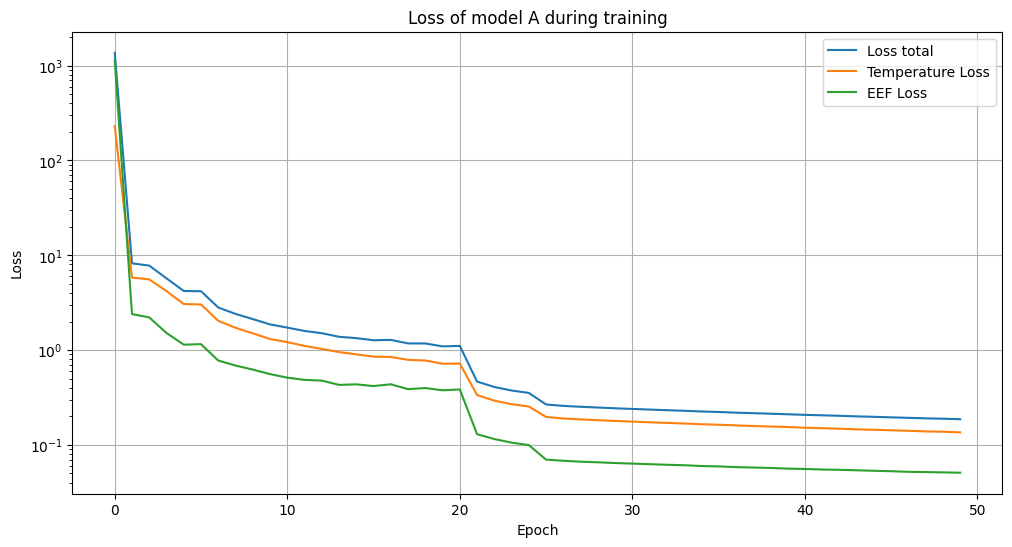

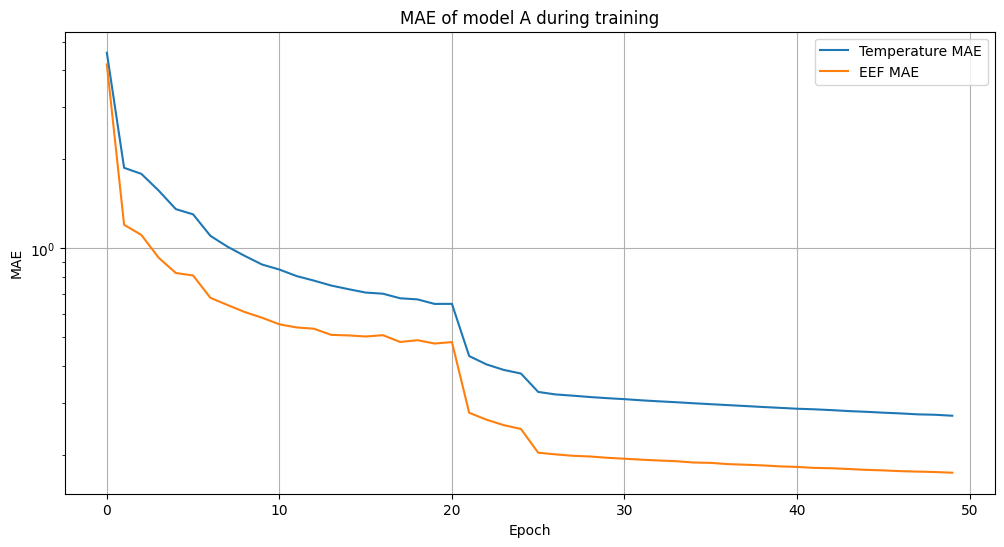

In [249]:
import matplotlib.pyplot as plt

# Obtener el historial de entrenamiento de model_a
history_a = history_model_a.history  # Asegúrate de acceder al atributo .history

# Graficar la pérdida total y la pérdida de temperatura y eef
plt.figure(figsize=(12, 6))
plt.plot(history_a['loss'], label='Loss total')  # Usa history_a en lugar de history_model_a
plt.plot(history_a['output_temperature_loss'], label='Temperature Loss')
plt.plot(history_a['output_eef_loss'], label='EEF Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss of model A during training')
plt.legend()
plt.grid(True)
plt.show()

# Graficar el MAE de temperatura y eef
plt.figure(figsize=(12, 6))
plt.plot(history_a['output_temperature_mae'], label='Temperature MAE')
plt.plot(history_a['output_eef_mae'], label='EEF MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.yscale('log')
plt.title('MAE of model A during training')
plt.legend()
plt.grid(True)
plt.show()

785/785 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step


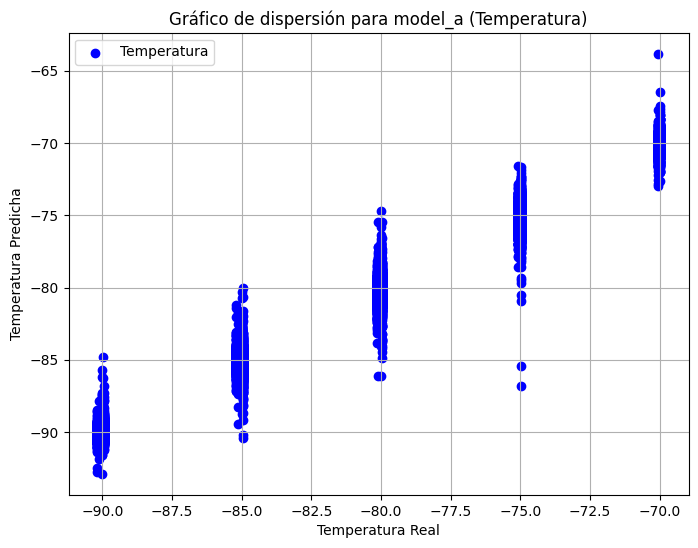

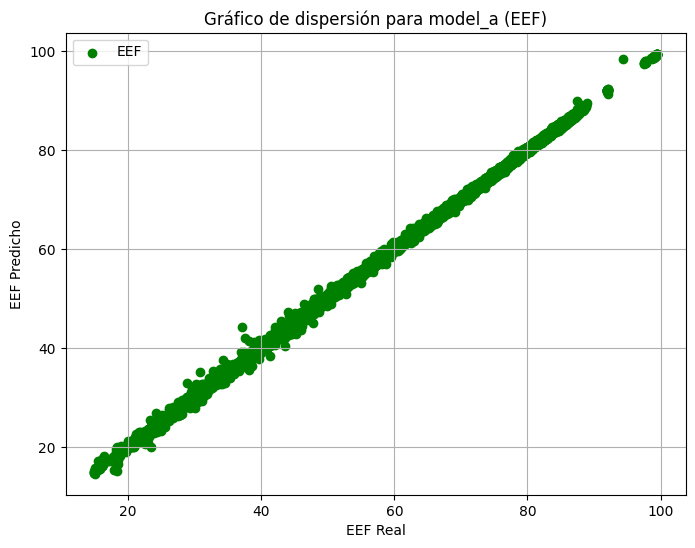

In [ ]:
import matplotlib.pyplot as plt

# Obtener predicciones del modelo
predictions_model_a = model_a.predict({
    'input_image': input_image_test,
    'input_temperature': input_temperature_test,
    'input_eef': input_eef_test
})

# Graficar dispersión para temperatura
plt.figure(figsize=(8, 6))
plt.scatter(input_temperature_test, predictions_model_a[0], color='blue', label='Temperature')
plt.title('Temperature scatterplot for model A')
plt.xlabel('Real Temperature')
plt.ylabel('Predicted Temperature')
plt.legend()
plt.grid(True)
plt.show()

# Graficar dispersión para EEF
plt.figure(figsize=(8, 6))
plt.scatter(input_eef_test, predictions_model_a[1], color='green', label='EEF')
plt.title('EEF scatter plot for model A')
plt.xlabel('Real EEF')
plt.ylabel('Predicted EEF')
plt.legend()
plt.grid(True)
plt.show()

### Model B

In [233]:
# Add the src directory to sys.path
import sys
import os

src_path = os.path.abspath('../')
sys.path.append(src_path)

try:
    # Combine src_path with MODEL_PATH to get the full path
    model_path = os.path.abspath(os.path.join(src_path, 'data/models'))
    print("Model directory path loaded successfully.")
except ImportError as e:
    print(f"Error importing MODEL_PATH: {e}")

MODEL_PATH = model_path

Model directory path loaded successfully.


In [239]:
import numpy as np

# Convertir los datos de entrada y salida en arrays de NumPy
input_image_train_bft = np.array(data_bft['image']['train'])
input_temperature_train_bft = np.array(data_bft['temperature']['train'])
input_eef_train_bft = np.array(data_bft['eef']['train'])

output_temperature_train_bft = np.array(data_bft['temperature']['train'])
output_eef_train_bft = np.array(data_bft['eef']['train'])

input_image_valid_bft = np.array(data_bft['image']['valid'])
input_temperature_valid_bft = np.array(data_bft['temperature']['valid'])
input_eef_valid_bft = np.array(data_bft['eef']['valid'])

output_temperature_valid_bft = np.array(data_bft['temperature']['valid'])
output_eef_valid_bft = np.array(data_bft['eef']['valid'])

In [242]:
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Definir los callbacks
callbacks_b = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'model_b.h5'), monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

# Entrenar el modelo_b_completo con los callbacks
history_model_b = model_b.fit(
    {'input_image_bft': input_image_train_bft,
     'input_temperature_bft': input_temperature_train_bft,
     'input_eef_bft': input_eef_train_bft},
    {'output_temperature_bft': output_temperature_train_bft,
     'output_eef_bft': output_eef_train_bft},
    epochs=50,
    batch_size=32,
    validation_data=(
        {'input_image_bft': input_image_valid_bft,
         'input_temperature_bft': input_temperature_valid_bft,
         'input_eef_bft': input_eef_valid_bft},
        {'output_temperature_bft': output_temperature_valid_bft,
         'output_eef_bft': output_eef_valid_bft}
    ),
    callbacks=callbacks_b
)

Epoch 1/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 343058.1875 - output_eef_bft_loss: 72908.0781 - output_eef_bft_mae: 44.8940 - output_temperature_bft_loss: 270150.0000 - output_temperature_bft_mae: 63.2121
Epoch 1: val_loss improved from inf to 171.19843, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 106s 124ms/step - loss: 342711.1875 - output_eef_bft_loss: 72834.5781 - output_eef_bft_mae: 44.8582 - output_temperature_bft_loss: 269876.4688 - output_temperature_bft_mae: 63.1572 - val_loss: 171.1984 - val_output_eef_bft_loss: 96.5047 - val_output_eef_bft_mae: 5.9569 - val_output_temperature_bft_loss: 74.4075 - val_output_temperature_bft_mae: 5.4319 - learning_rate: 0.0010
Epoch 2/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 56.5976 - output_eef_bft_loss: 31.5019 - output_eef_bft_mae: 3.5057 - output_temperature_bft_loss: 25.0956 - output_temperature_bft_mae: 3.2813
Epoch 2: val_loss improved from 171.19843 to 12.48453, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 102s 123ms/step - loss: 56.5625 - output_eef_bft_loss: 31.4817 - output_eef_bft_mae: 3.5045 - output_temperature_bft_loss: 25.0808 - output_temperature_bft_mae: 3.2803 - val_loss: 12.4845 - val_output_eef_bft_loss: 6.4235 - val_output_eef_bft_mae: 2.1141 - val_output_temperature_bft_loss: 6.0620 - val_output_temperature_bft_mae: 1.9687 - learning_rate: 0.0010
Epoch 3/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 8.2966 - output_eef_bft_loss: 3.6141 - output_eef_bft_mae: 1.4507 - output_temperature_bft_loss: 4.6826 - output_temperature_bft_mae: 1.6540
Epoch 3: val_loss improved from 12.48453 to 6.03567, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 134s 113ms/step - loss: 8.2960 - output_eef_bft_loss: 3.6137 - output_eef_bft_mae: 1.4506 - output_temperature_bft_loss: 4.6824 - output_temperature_bft_mae: 1.6540 - val_loss: 6.0357 - val_output_eef_bft_loss: 2.1647 - val_output_eef_bft_mae: 1.0978 - val_output_temperature_bft_loss: 3.8640 - val_output_temperature_bft_mae: 1.5378 - learning_rate: 0.0010
Epoch 4/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 6.5813 - output_eef_bft_loss: 2.5522 - output_eef_bft_mae: 1.2094 - output_temperature_bft_loss: 4.0291 - output_temperature_bft_mae: 1.5322
Epoch 4: val_loss did not improve from 6.03567
829/829 ━━━━━━━━━━━━━━━━━━━━ 94s 113ms/step - loss: 6.5810 - output_eef_bft_loss: 2.5520 - output_eef_bft_mae: 1.2094 - output_temperature_bft_loss: 4.0290 - output_temperature_bft_mae: 1.5322 - val_loss: 9.7076 - val_output_eef_bft_loss: 2.9201 - val_output_eef_bft_mae: 1.3766 - val_output_temperature_bft_loss: 6.7800 - val_output_temperature_bft_mae: 2.1402 -

829/829 ━━━━━━━━━━━━━━━━━━━━ 108s 130ms/step - loss: 3.3557 - output_eef_bft_loss: 0.9551 - output_eef_bft_mae: 0.7366 - output_temperature_bft_loss: 2.4006 - output_temperature_bft_mae: 1.2053 - val_loss: 3.1134 - val_output_eef_bft_loss: 0.8994 - val_output_eef_bft_mae: 0.7031 - val_output_temperature_bft_loss: 2.2094 - val_output_temperature_bft_mae: 1.1701 - learning_rate: 2.0000e-04
Epoch 8/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 3.0554 - output_eef_bft_loss: 0.8378 - output_eef_bft_mae: 0.6983 - output_temperature_bft_loss: 2.2176 - output_temperature_bft_mae: 1.1685
Epoch 8: val_loss improved from 3.11341 to 3.09795, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 107s 129ms/step - loss: 3.0553 - output_eef_bft_loss: 0.8378 - output_eef_bft_mae: 0.6983 - output_temperature_bft_loss: 2.2176 - output_temperature_bft_mae: 1.1685 - val_loss: 3.0980 - val_output_eef_bft_loss: 0.8739 - val_output_eef_bft_mae: 0.6989 - val_output_temperature_bft_loss: 2.2199 - val_output_temperature_bft_mae: 1.1670 - learning_rate: 2.0000e-04
Epoch 9/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.8921 - output_eef_bft_loss: 0.7852 - output_eef_bft_mae: 0.6806 - output_temperature_bft_loss: 2.1069 - output_temperature_bft_mae: 1.1403
Epoch 9: val_loss did not improve from 3.09795
829/829 ━━━━━━━━━━━━━━━━━━━━ 97s 117ms/step - loss: 2.8921 - output_eef_bft_loss: 0.7853 - output_eef_bft_mae: 0.6806 - output_temperature_bft_loss: 2.1069 - output_temperature_bft_mae: 1.1403 - val_loss: 3.3502 - val_output_eef_bft_loss: 1.1893 - val_output_eef_bft_mae: 0.8613 - val_output_temperature_bft_loss: 2.1570 - val_output_temperature_bft_mae: 1.14

829/829 ━━━━━━━━━━━━━━━━━━━━ 100s 121ms/step - loss: 2.8958 - output_eef_bft_loss: 0.8005 - output_eef_bft_mae: 0.6902 - output_temperature_bft_loss: 2.0953 - output_temperature_bft_mae: 1.1377 - val_loss: 2.9419 - val_output_eef_bft_loss: 0.7125 - val_output_eef_bft_mae: 0.6212 - val_output_temperature_bft_loss: 2.2251 - val_output_temperature_bft_mae: 1.1619 - learning_rate: 2.0000e-04
Epoch 11/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.9892 - output_eef_bft_loss: 0.8586 - output_eef_bft_mae: 0.7191 - output_temperature_bft_loss: 2.1307 - output_temperature_bft_mae: 1.1473
Epoch 11: val_loss did not improve from 2.94188
829/829 ━━━━━━━━━━━━━━━━━━━━ 97s 117ms/step - loss: 2.9892 - output_eef_bft_loss: 0.8586 - output_eef_bft_mae: 0.7191 - output_temperature_bft_loss: 2.1307 - output_temperature_bft_mae: 1.1473 - val_loss: 3.6980 - val_output_eef_bft_loss: 1.3552 - val_output_eef_bft_mae: 0.9414 - val_output_temperature_bft_loss: 2.3385 - val_output_temperature_bft_mae: 1.

829/829 ━━━━━━━━━━━━━━━━━━━━ 88s 106ms/step - loss: 2.3354 - output_eef_bft_loss: 0.5624 - output_eef_bft_mae: 0.5673 - output_temperature_bft_loss: 1.7730 - output_temperature_bft_mae: 1.0443 - val_loss: 2.4870 - val_output_eef_bft_loss: 0.6267 - val_output_eef_bft_mae: 0.5863 - val_output_temperature_bft_loss: 1.8570 - val_output_temperature_bft_mae: 1.0593 - learning_rate: 4.0000e-05
Epoch 15/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.0742 - output_eef_bft_loss: 0.4669 - output_eef_bft_mae: 0.5233 - output_temperature_bft_loss: 1.6073 - output_temperature_bft_mae: 0.9964
Epoch 15: val_loss did not improve from 2.48705
829/829 ━━━━━━━━━━━━━━━━━━━━ 86s 104ms/step - loss: 2.0743 - output_eef_bft_loss: 0.4669 - output_eef_bft_mae: 0.5233 - output_temperature_bft_loss: 1.6074 - output_temperature_bft_mae: 0.9964 - val_loss: 2.6186 - val_output_eef_bft_loss: 0.7482 - val_output_eef_bft_mae: 0.6487 - val_output_temperature_bft_loss: 1.8669 - val_output_temperature_bft_mae: 1.06

829/829 ━━━━━━━━━━━━━━━━━━━━ 89s 107ms/step - loss: 2.0858 - output_eef_bft_loss: 0.4679 - output_eef_bft_mae: 0.5251 - output_temperature_bft_loss: 1.6179 - output_temperature_bft_mae: 1.0003 - val_loss: 2.4798 - val_output_eef_bft_loss: 0.5535 - val_output_eef_bft_mae: 0.5450 - val_output_temperature_bft_loss: 1.9224 - val_output_temperature_bft_mae: 1.0760 - learning_rate: 4.0000e-05
Epoch 17/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 2.0592 - output_eef_bft_loss: 0.4721 - output_eef_bft_mae: 0.5277 - output_temperature_bft_loss: 1.5870 - output_temperature_bft_mae: 0.9918
Epoch 17: val_loss did not improve from 2.47978
829/829 ━━━━━━━━━━━━━━━━━━━━ 89s 107ms/step - loss: 2.0592 - output_eef_bft_loss: 0.4721 - output_eef_bft_mae: 0.5277 - output_temperature_bft_loss: 1.5870 - output_temperature_bft_mae: 0.9918 - val_loss: 2.6023 - val_output_eef_bft_loss: 0.7372 - val_output_eef_bft_mae: 0.6616 - val_output_temperature_bft_loss: 1.8620 - val_output_temperature_bft_mae: 1.0

829/829 ━━━━━━━━━━━━━━━━━━━━ 89s 108ms/step - loss: 1.7736 - output_eef_bft_loss: 0.3541 - output_eef_bft_mae: 0.4543 - output_temperature_bft_loss: 1.4194 - output_temperature_bft_mae: 0.9300 - val_loss: 2.1454 - val_output_eef_bft_loss: 0.4932 - val_output_eef_bft_mae: 0.5040 - val_output_temperature_bft_loss: 1.6492 - val_output_temperature_bft_mae: 0.9921 - learning_rate: 8.0000e-06
Epoch 21/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.6925 - output_eef_bft_loss: 0.3376 - output_eef_bft_mae: 0.4429 - output_temperature_bft_loss: 1.3549 - output_temperature_bft_mae: 0.9110
Epoch 21: val_loss improved from 2.14543 to 2.14177, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 1.6925 - output_eef_bft_loss: 0.3376 - output_eef_bft_mae: 0.4429 - output_temperature_bft_loss: 1.3549 - output_temperature_bft_mae: 0.9110 - val_loss: 2.1418 - val_output_eef_bft_loss: 0.4706 - val_output_eef_bft_mae: 0.4896 - val_output_temperature_bft_loss: 1.6680 - val_output_temperature_bft_mae: 1.0015 - learning_rate: 8.0000e-06
Epoch 22/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.7024 - output_eef_bft_loss: 0.3416 - output_eef_bft_mae: 0.4412 - output_temperature_bft_loss: 1.3608 - output_temperature_bft_mae: 0.9117
Epoch 22: val_loss did not improve from 2.14177
829/829 ━━━━━━━━━━━━━━━━━━━━ 86s 103ms/step - loss: 1.7024 - output_eef_bft_loss: 0.3416 - output_eef_bft_mae: 0.4412 - output_temperature_bft_loss: 1.3608 - output_temperature_bft_mae: 0.9117 - val_loss: 2.1684 - val_output_eef_bft_loss: 0.4963 - val_output_eef_bft_mae: 0.5104 - val_output_temperature_bft_loss: 1.6693 - val_output_temperature_bft_mae: 0.99

829/829 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 1.6846 - output_eef_bft_loss: 0.3304 - output_eef_bft_mae: 0.4391 - output_temperature_bft_loss: 1.3542 - output_temperature_bft_mae: 0.9114 - val_loss: 2.0960 - val_output_eef_bft_loss: 0.4618 - val_output_eef_bft_mae: 0.4816 - val_output_temperature_bft_loss: 1.6311 - val_output_temperature_bft_mae: 0.9877 - learning_rate: 8.0000e-06
Epoch 24/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.6770 - output_eef_bft_loss: 0.3325 - output_eef_bft_mae: 0.4400 - output_temperature_bft_loss: 1.3445 - output_temperature_bft_mae: 0.9067
Epoch 24: val_loss improved from 2.09600 to 2.09548, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 88s 106ms/step - loss: 1.6770 - output_eef_bft_loss: 0.3325 - output_eef_bft_mae: 0.4400 - output_temperature_bft_loss: 1.3445 - output_temperature_bft_mae: 0.9067 - val_loss: 2.0955 - val_output_eef_bft_loss: 0.4682 - val_output_eef_bft_mae: 0.4852 - val_output_temperature_bft_loss: 1.6246 - val_output_temperature_bft_mae: 0.9870 - learning_rate: 8.0000e-06
Epoch 25/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.6749 - output_eef_bft_loss: 0.3272 - output_eef_bft_mae: 0.4339 - output_temperature_bft_loss: 1.3477 - output_temperature_bft_mae: 0.9078
Epoch 25: val_loss improved from 2.09548 to 2.08964, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 1.6748 - output_eef_bft_loss: 0.3272 - output_eef_bft_mae: 0.4339 - output_temperature_bft_loss: 1.3477 - output_temperature_bft_mae: 0.9078 - val_loss: 2.0896 - val_output_eef_bft_loss: 0.4828 - val_output_eef_bft_mae: 0.5036 - val_output_temperature_bft_loss: 1.6041 - val_output_temperature_bft_mae: 0.9795 - learning_rate: 8.0000e-06
Epoch 26/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.6495 - output_eef_bft_loss: 0.3271 - output_eef_bft_mae: 0.4365 - output_temperature_bft_loss: 1.3224 - output_temperature_bft_mae: 0.9013
Epoch 26: val_loss improved from 2.08964 to 2.04341, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 90s 108ms/step - loss: 1.6495 - output_eef_bft_loss: 0.3271 - output_eef_bft_mae: 0.4365 - output_temperature_bft_loss: 1.3224 - output_temperature_bft_mae: 0.9013 - val_loss: 2.0434 - val_output_eef_bft_loss: 0.4555 - val_output_eef_bft_mae: 0.4781 - val_output_temperature_bft_loss: 1.5850 - val_output_temperature_bft_mae: 0.9729 - learning_rate: 8.0000e-06
Epoch 27/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.6153 - output_eef_bft_loss: 0.3216 - output_eef_bft_mae: 0.4348 - output_temperature_bft_loss: 1.2937 - output_temperature_bft_mae: 0.8903
Epoch 27: val_loss did not improve from 2.04341
829/829 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 1.6154 - output_eef_bft_loss: 0.3216 - output_eef_bft_mae: 0.4348 - output_temperature_bft_loss: 1.2937 - output_temperature_bft_mae: 0.8903 - val_loss: 2.1752 - val_output_eef_bft_loss: 0.5493 - val_output_eef_bft_mae: 0.5459 - val_output_temperature_bft_loss: 1.6232 - val_output_temperature_bft_mae: 0.98

829/829 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 1.6198 - output_eef_bft_loss: 0.3245 - output_eef_bft_mae: 0.4337 - output_temperature_bft_loss: 1.2953 - output_temperature_bft_mae: 0.8891 - val_loss: 2.0348 - val_output_eef_bft_loss: 0.4569 - val_output_eef_bft_mae: 0.4826 - val_output_temperature_bft_loss: 1.5753 - val_output_temperature_bft_mae: 0.9663 - learning_rate: 8.0000e-06
Epoch 29/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.5977 - output_eef_bft_loss: 0.3156 - output_eef_bft_mae: 0.4286 - output_temperature_bft_loss: 1.2821 - output_temperature_bft_mae: 0.8852
Epoch 29: val_loss did not improve from 2.03485
829/829 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 1.5977 - output_eef_bft_loss: 0.3156 - output_eef_bft_mae: 0.4286 - output_temperature_bft_loss: 1.2821 - output_temperature_bft_mae: 0.8852 - val_loss: 2.0479 - val_output_eef_bft_loss: 0.4446 - val_output_eef_bft_mae: 0.4710 - val_output_temperature_bft_loss: 1.6006 - val_output_temperature_bft_mae: 0.97

829/829 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 1.4476 - output_eef_bft_loss: 0.2640 - output_eef_bft_mae: 0.3912 - output_temperature_bft_loss: 1.1837 - output_temperature_bft_mae: 0.8494 - val_loss: 1.9473 - val_output_eef_bft_loss: 0.4239 - val_output_eef_bft_mae: 0.4542 - val_output_temperature_bft_loss: 1.5208 - val_output_temperature_bft_mae: 0.9489 - learning_rate: 1.6000e-06
Epoch 33/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.4347 - output_eef_bft_loss: 0.2626 - output_eef_bft_mae: 0.3855 - output_temperature_bft_loss: 1.1721 - output_temperature_bft_mae: 0.8475
Epoch 33: val_loss improved from 1.94727 to 1.93904, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 1.4347 - output_eef_bft_loss: 0.2625 - output_eef_bft_mae: 0.3855 - output_temperature_bft_loss: 1.1721 - output_temperature_bft_mae: 0.8475 - val_loss: 1.9390 - val_output_eef_bft_loss: 0.4277 - val_output_eef_bft_mae: 0.4582 - val_output_temperature_bft_loss: 1.5088 - val_output_temperature_bft_mae: 0.9457 - learning_rate: 1.6000e-06
Epoch 34/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.4109 - output_eef_bft_loss: 0.2513 - output_eef_bft_mae: 0.3821 - output_temperature_bft_loss: 1.1596 - output_temperature_bft_mae: 0.8403
Epoch 34: val_loss did not improve from 1.93904
829/829 ━━━━━━━━━━━━━━━━━━━━ 87s 105ms/step - loss: 1.4109 - output_eef_bft_loss: 0.2513 - output_eef_bft_mae: 0.3821 - output_temperature_bft_loss: 1.1596 - output_temperature_bft_mae: 0.8403 - val_loss: 1.9497 - val_output_eef_bft_loss: 0.4325 - val_output_eef_bft_mae: 0.4606 - val_output_temperature_bft_loss: 1.5148 - val_output_temperature_bft_mae: 0.94

829/829 ━━━━━━━━━━━━━━━━━━━━ 90s 108ms/step - loss: 1.4443 - output_eef_bft_loss: 0.2636 - output_eef_bft_mae: 0.3869 - output_temperature_bft_loss: 1.1807 - output_temperature_bft_mae: 0.8479 - val_loss: 1.9285 - val_output_eef_bft_loss: 0.4228 - val_output_eef_bft_mae: 0.4530 - val_output_temperature_bft_loss: 1.5031 - val_output_temperature_bft_mae: 0.9432 - learning_rate: 1.6000e-06
Epoch 36/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.4254 - output_eef_bft_loss: 0.2558 - output_eef_bft_mae: 0.3835 - output_temperature_bft_loss: 1.1695 - output_temperature_bft_mae: 0.8409
Epoch 36: val_loss did not improve from 1.92847
829/829 ━━━━━━━━━━━━━━━━━━━━ 86s 104ms/step - loss: 1.4254 - output_eef_bft_loss: 0.2558 - output_eef_bft_mae: 0.3835 - output_temperature_bft_loss: 1.1695 - output_temperature_bft_mae: 0.8409 - val_loss: 1.9381 - val_output_eef_bft_loss: 0.4215 - val_output_eef_bft_mae: 0.4526 - val_output_temperature_bft_loss: 1.5141 - val_output_temperature_bft_mae: 0.94

829/829 ━━━━━━━━━━━━━━━━━━━━ 134s 95ms/step - loss: 1.4011 - output_eef_bft_loss: 0.2621 - output_eef_bft_mae: 0.3880 - output_temperature_bft_loss: 1.1390 - output_temperature_bft_mae: 0.8316 - val_loss: 1.9266 - val_output_eef_bft_loss: 0.4224 - val_output_eef_bft_mae: 0.4542 - val_output_temperature_bft_loss: 1.5018 - val_output_temperature_bft_mae: 0.9441 - learning_rate: 1.6000e-06
Epoch 38/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.3980 - output_eef_bft_loss: 0.2538 - output_eef_bft_mae: 0.3842 - output_temperature_bft_loss: 1.1443 - output_temperature_bft_mae: 0.8313
Epoch 38: val_loss did not improve from 1.92665
829/829 ━━━━━━━━━━━━━━━━━━━━ 79s 95ms/step - loss: 1.3980 - output_eef_bft_loss: 0.2538 - output_eef_bft_mae: 0.3842 - output_temperature_bft_loss: 1.1443 - output_temperature_bft_mae: 0.8313 - val_loss: 1.9360 - val_output_eef_bft_loss: 0.4233 - val_output_eef_bft_mae: 0.4552 - val_output_temperature_bft_loss: 1.5102 - val_output_temperature_bft_mae: 0.946

829/829 ━━━━━━━━━━━━━━━━━━━━ 79s 95ms/step - loss: 1.4056 - output_eef_bft_loss: 0.2571 - output_eef_bft_mae: 0.3822 - output_temperature_bft_loss: 1.1485 - output_temperature_bft_mae: 0.8356 - val_loss: 1.9182 - val_output_eef_bft_loss: 0.4194 - val_output_eef_bft_mae: 0.4504 - val_output_temperature_bft_loss: 1.4964 - val_output_temperature_bft_mae: 0.9400 - learning_rate: 1.6000e-06
Epoch 41/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.3962 - output_eef_bft_loss: 0.2494 - output_eef_bft_mae: 0.3797 - output_temperature_bft_loss: 1.1468 - output_temperature_bft_mae: 0.8339
Epoch 41: val_loss improved from 1.91819 to 1.90824, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 79s 96ms/step - loss: 1.3962 - output_eef_bft_loss: 0.2494 - output_eef_bft_mae: 0.3797 - output_temperature_bft_loss: 1.1468 - output_temperature_bft_mae: 0.8339 - val_loss: 1.9082 - val_output_eef_bft_loss: 0.4156 - val_output_eef_bft_mae: 0.4484 - val_output_temperature_bft_loss: 1.4902 - val_output_temperature_bft_mae: 0.9390 - learning_rate: 1.6000e-06
Epoch 42/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.3724 - output_eef_bft_loss: 0.2498 - output_eef_bft_mae: 0.3802 - output_temperature_bft_loss: 1.1226 - output_temperature_bft_mae: 0.8231
Epoch 42: val_loss did not improve from 1.90824
829/829 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - loss: 1.3724 - output_eef_bft_loss: 0.2498 - output_eef_bft_mae: 0.3802 - output_temperature_bft_loss: 1.1227 - output_temperature_bft_mae: 0.8231 - val_loss: 1.9093 - val_output_eef_bft_loss: 0.4242 - val_output_eef_bft_mae: 0.4550 - val_output_temperature_bft_loss: 1.4828 - val_output_temperature_bft_mae: 0.9353

829/829 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - loss: 1.3774 - output_eef_bft_loss: 0.2424 - output_eef_bft_mae: 0.3748 - output_temperature_bft_loss: 1.1350 - output_temperature_bft_mae: 0.8301 - val_loss: 1.9040 - val_output_eef_bft_loss: 0.4159 - val_output_eef_bft_mae: 0.4478 - val_output_temperature_bft_loss: 1.4857 - val_output_temperature_bft_mae: 0.9368 - learning_rate: 1.6000e-06
Epoch 45/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.3571 - output_eef_bft_loss: 0.2470 - output_eef_bft_mae: 0.3772 - output_temperature_bft_loss: 1.1101 - output_temperature_bft_mae: 0.8200
Epoch 45: val_loss improved from 1.90402 to 1.90235, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - loss: 1.3571 - output_eef_bft_loss: 0.2470 - output_eef_bft_mae: 0.3772 - output_temperature_bft_loss: 1.1101 - output_temperature_bft_mae: 0.8200 - val_loss: 1.9023 - val_output_eef_bft_loss: 0.4200 - val_output_eef_bft_mae: 0.4525 - val_output_temperature_bft_loss: 1.4799 - val_output_temperature_bft_mae: 0.9342 - learning_rate: 1.6000e-06
Epoch 46/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.3574 - output_eef_bft_loss: 0.2418 - output_eef_bft_mae: 0.3743 - output_temperature_bft_loss: 1.1155 - output_temperature_bft_mae: 0.8233
Epoch 46: val_loss improved from 1.90235 to 1.89499, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - loss: 1.3574 - output_eef_bft_loss: 0.2418 - output_eef_bft_mae: 0.3743 - output_temperature_bft_loss: 1.1156 - output_temperature_bft_mae: 0.8233 - val_loss: 1.8950 - val_output_eef_bft_loss: 0.4135 - val_output_eef_bft_mae: 0.4464 - val_output_temperature_bft_loss: 1.4791 - val_output_temperature_bft_mae: 0.9353 - learning_rate: 1.6000e-06
Epoch 47/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.3650 - output_eef_bft_loss: 0.2477 - output_eef_bft_mae: 0.3780 - output_temperature_bft_loss: 1.1173 - output_temperature_bft_mae: 0.8219
Epoch 47: val_loss improved from 1.89499 to 1.89438, saving model to c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\model_b.h5


829/829 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - loss: 1.3650 - output_eef_bft_loss: 0.2477 - output_eef_bft_mae: 0.3780 - output_temperature_bft_loss: 1.1173 - output_temperature_bft_mae: 0.8219 - val_loss: 1.8944 - val_output_eef_bft_loss: 0.4142 - val_output_eef_bft_mae: 0.4475 - val_output_temperature_bft_loss: 1.4777 - val_output_temperature_bft_mae: 0.9323 - learning_rate: 1.6000e-06
Epoch 48/50
829/829 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.3668 - output_eef_bft_loss: 0.2483 - output_eef_bft_mae: 0.3748 - output_temperature_bft_loss: 1.1185 - output_temperature_bft_mae: 0.8237
Epoch 48: val_loss did not improve from 1.89438
829/829 ━━━━━━━━━━━━━━━━━━━━ 79s 95ms/step - loss: 1.3668 - output_eef_bft_loss: 0.2483 - output_eef_bft_mae: 0.3748 - output_temperature_bft_loss: 1.1185 - output_temperature_bft_mae: 0.8237 - val_loss: 1.9019 - val_output_eef_bft_loss: 0.4269 - val_output_eef_bft_mae: 0.4593 - val_output_temperature_bft_loss: 1.4726 - val_output_temperature_bft_mae: 0.9326

829/829 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - loss: 1.3531 - output_eef_bft_loss: 0.2404 - output_eef_bft_mae: 0.3732 - output_temperature_bft_loss: 1.1127 - output_temperature_bft_mae: 0.8214 - val_loss: 1.8916 - val_output_eef_bft_loss: 0.4201 - val_output_eef_bft_mae: 0.4534 - val_output_temperature_bft_loss: 1.4692 - val_output_temperature_bft_mae: 0.9310 - learning_rate: 1.6000e-06
Restoring model weights from the end of the best epoch: 50.


In [243]:
import pickle

# Nombre del archivo en el que guardar el historial
path_history_model_b = os.path.join(MODEL_PATH, "history_model_b.pkl")

# Guardar el historial en el archivo usando pickle
with open(path_history_model_b, 'wb') as f:
    pickle.dump(history_model_b.history, f)

print("El historial se ha guardado en el archivo", path_history_model_b)

El historial se ha guardado en el archivo c:\Users\UX450FDX\Documents\Projects\PLATO_CNN\data\models\history_model_b.pkl


In [ ]:
#from keras.models import load_model
# Load the model
#path_model_b = os.path.join(MODEL_PATH, "model_b.h5")
#model_b = load_model(path_model_a)


Evaluate the model

In [244]:
# Convertir los datos de prueba de entrada y salida en arrays de NumPy
input_image_test_bft = np.array(data_bft['image']['test'])
input_temperature_test_bft = np.array(data_bft['temperature']['test'])
input_eef_test_bft = np.array(data_bft['eef']['test'])

output_temperature_test_bft = np.array(data_bft['temperature']['test'])
output_eef_test_bft = np.array(data_bft['eef']['test'])

In [245]:
# Evaluar model_b en el conjunto de datos de prueba
metrics_model_b = model_b.evaluate(
    {'input_image_bft': input_image_test_bft,
     'input_temperature_bft': input_temperature_test_bft,
     'input_eef_bft': input_eef_test_bft},
    {'output_temperature_bft': output_temperature_test_bft,
     'output_eef_bft': output_eef_test_bft}
)

print("Métricas de model_a:")
print(" - Loss total:", metrics_model_b[0])
print(" - Loss de la salida de temperatura:", metrics_model_b[1])
print(" - Loss de la salida de eef:", metrics_model_b[2])
print(" - MAE de la salida de temperatura:", metrics_model_b[3])
print(" - MAE de la salida de eef:", metrics_model_b[4])

178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.8106 - output_eef_bft_loss: 0.4228 - output_eef_bft_mae: 0.4497 - output_temperature_bft_loss: 1.3878 - output_temperature_bft_mae: 0.8652
Métricas de model_a:
 - Loss total: 2.107844114303589
 - Loss de la salida de temperatura: 1.6789199113845825
 - Loss de la salida de eef: 0.4276357591152191
 - MAE de la salida de temperatura: 0.4526853859424591
 - MAE de la salida de eef: 0.9093449711799622


Plot the history model

In [247]:
print(history_b.keys())

dict_keys(['loss', 'output_eef_bft_loss', 'output_eef_bft_mae', 'output_temperature_bft_loss', 'output_temperature_bft_mae', 'val_loss', 'val_output_eef_bft_loss', 'val_output_eef_bft_mae', 'val_output_temperature_bft_loss', 'val_output_temperature_bft_mae', 'learning_rate'])


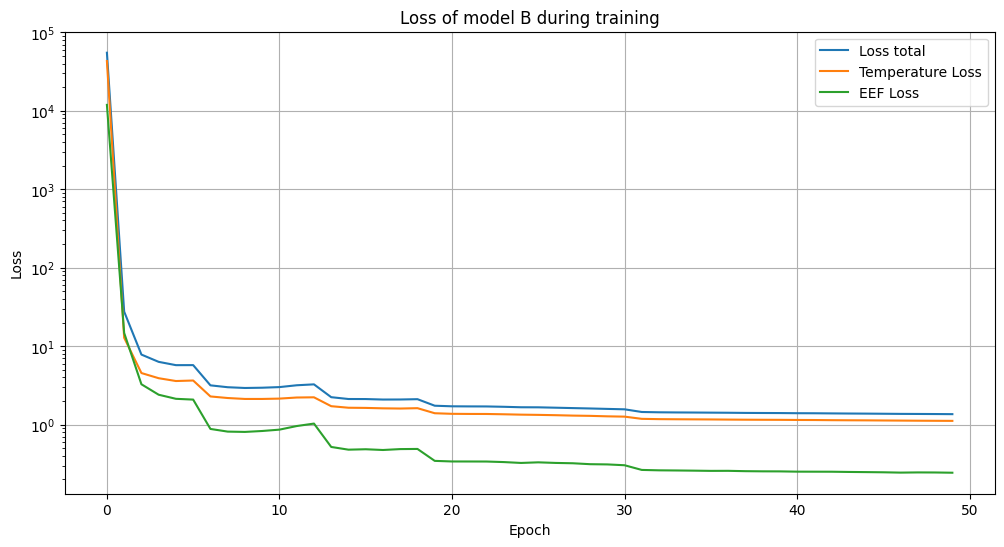

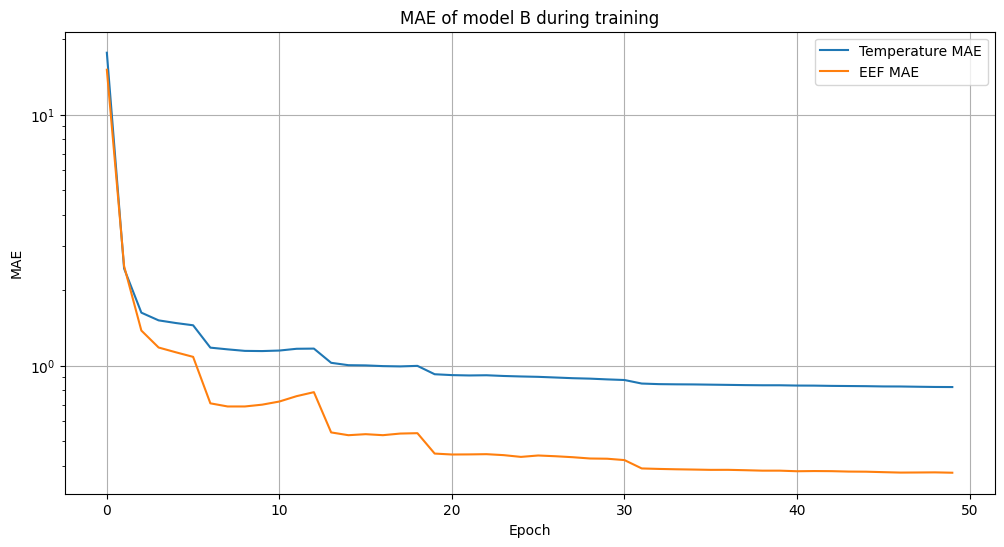

In [248]:
import matplotlib.pyplot as plt

# Obtener el historial de entrenamiento de model_a
history_b = history_model_b.history  # Asegúrate de acceder al atributo .history

# Graficar la pérdida total y la pérdida de temperatura y eef
plt.figure(figsize=(12, 6))
plt.plot(history_b['loss'], label='Loss total')  # Usa history_a en lugar de history_model_a
plt.plot(history_b['output_temperature_bft_loss'], label='Temperature Loss')
plt.plot(history_b['output_eef_bft_loss'], label='EEF Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss of model B during training')
plt.legend()
plt.grid(True)
plt.show()

# Graficar el MAE de temperatura y eef
plt.figure(figsize=(12, 6))
plt.plot(history_b['output_temperature_bft_mae'], label='Temperature MAE')
plt.plot(history_b['output_eef_bft_mae'], label='EEF MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.yscale('log')
plt.title('MAE of model B during training')
plt.legend()
plt.grid(True)
plt.show()


In [251]:
import matplotlib.pyplot as plt

# Obtener predicciones de model_b
predictions_model_b = model_b.predict(
    {'input_image_bft': input_image_test_bft,
     'input_temperature_bft': input_temperature_test_bft,
     'input_eef_bft': input_eef_test_bft},)

178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


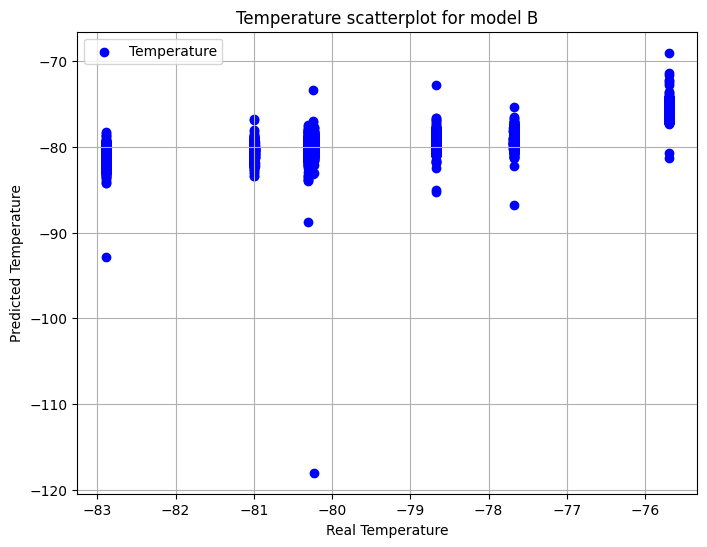

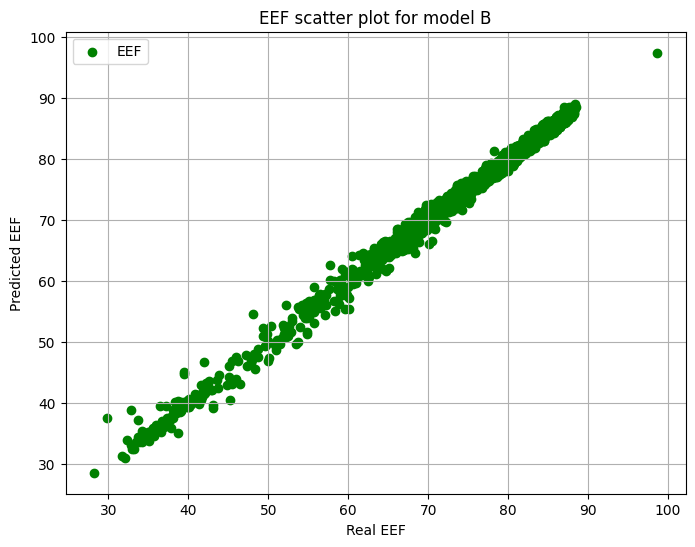

In [253]:
# Graficar dispersión para temperatura
plt.figure(figsize=(8, 6))
plt.scatter(input_temperature_test_bft, predictions_model_b[0], color='blue', label='Temperature')
plt.title('Temperature scatterplot for model B')
plt.xlabel('Real Temperature')
plt.ylabel('Predicted Temperature')
plt.legend()
plt.grid(True)
plt.show()

# Graficar dispersión para EEF
plt.figure(figsize=(8, 6))
plt.scatter(input_eef_test_bft, predictions_model_b[1], color='green', label='EEF')
plt.title('EEF scatter plot for model B')
plt.xlabel('Real EEF')
plt.ylabel('Predicted EEF')
plt.legend()
plt.grid(True)
plt.show()

## 4. Predict the models

In [271]:
from keras.models import load_model
from keras.losses import MeanSquaredError

# Diccionario de objetos personalizados
custom_objects = {'mse': MeanSquaredError()}

# Load the model
path_model_a = os.path.join(MODEL_PATH, "model_a.h5")
path_model_b = os.path.join(MODEL_PATH, "model_b.h5")

model_a = load_model(path_model_a, custom_objects=custom_objects)
model_b = load_model(path_model_b, custom_objects=custom_objects)

In [260]:
input_image = np.array(data_splits_by_model['EM']['Plateaux']['image']['test'])
input_temperature = np.array(data_splits_by_model['EM']['Plateaux']['temperature']['test'])
input_eef = np.array(data_splits_by_model['EM']['Plateaux']['eef']['test'])

print("Shape of input_image_bft:", input_image.shape)
print("Shape of input_temperature_bft:", input_temperature.shape)
print("Shape of input_eef_bft:", input_eef.shape)

Shape of input_image_bft: (3690, 11, 11, 1)
Shape of input_temperature_bft: (3690,)
Shape of input_eef_bft: (3690,)


In [263]:
for model, subtypes in data_splits_by_model.items():
    print(f"Model: {model}")
    for image_type, splits in subtypes.items():
        print(f"  Image Type: {image_type}")
        for data_type, sets in splits.items():
            for split, data in sets.items():
                print(f"    {data_type} - {split}: {data.shape}")

Model: EM
  Image Type: Plateaux
    image - train: (17220, 11, 11, 1)
    image - valid: (3690, 11, 11, 1)
    image - test: (3690, 11, 11, 1)
    temperature - train: (17220,)
    temperature - valid: (3690,)
    temperature - test: (3690,)
    eef - train: (17220,)
    eef - valid: (3690,)
    eef - test: (3690,)
  Image Type: BFT
    image - train: (3788, 11, 11, 1)
    image - valid: (812, 11, 11, 1)
    image - test: (812, 11, 11, 1)
    temperature - train: (3788,)
    temperature - valid: (812,)
    temperature - test: (812,)
    eef - train: (3788,)
    eef - valid: (812,)
    eef - test: (812,)
Model: FM3
  Image Type: Plateaux
    image - train: (17220, 11, 11, 1)
    image - valid: (3690, 11, 11, 1)
    image - test: (3690, 11, 11, 1)
    temperature - train: (17220,)
    temperature - valid: (3690,)
    temperature - test: (3690,)
    eef - train: (17220,)
    eef - valid: (3690,)
    eef - test: (3690,)
  Image Type: BFT
    image - train: (3788, 11, 11, 1)
    image - va

Dimensiones de entrada para model_a y model_b:

* model_a espera entradas con las siguientes formas:
- input_image: (n_samples, 11, 11, 1)
- input_temperature: (n_samples, 1)
- input_eef: (n_samples, 1)

* model_b espera entradas con las siguientes formas:
- input_image_bft: (n_samples, 11, 11, 1)
- input_temperature_bft: (n_samples, 1)
- input_eef_bft: (n_samples, 1)

In [272]:
import numpy as np

def predecir_modelo(modelo ,model_a, model_b, conjuntos_datos_por_modelo):
    # Obtener las imágenes de prueba, temperaturas y EEF del diccionario de datos del modelo A
    input_image = np.array(conjuntos_datos_por_modelo[modelo]['Plateaux']['image']['test'])
    input_temperature = np.array(conjuntos_datos_por_modelo[modelo]['Plateaux']['temperature']['test'])
    input_eef = np.array(conjuntos_datos_por_modelo[modelo]['Plateaux']['eef']['test'])

    # Obtener las predicciones del modelo A para las imágenes de prueba
    predicciones_temp_a, predicciones_eef_a = model_a.predict({'input_image': input_image,
                                                               'input_temperature': input_temperature,
                                                               'input_eef': input_eef})

    # Preparar los datos para el modelo B
    datos_modelo_b = {'input_image_bft': input_image,
                      'input_temperature_bft': predicciones_temp_a,
                      'input_eef_bft': predicciones_eef_a}

    # Obtener las predicciones del modelo B
    predicciones_b = model_b.predict(datos_modelo_b)

    # Desempaquetar las predicciones del modelo B
    predicciones_temp_b = predicciones_b[0]
    predicciones_eef_b = predicciones_b[1]

    return predicciones_temp_b, predicciones_eef_b

In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplot_temperature_predictions(model, predictions_temp_b, conf_level=0.95):
    """
    Plot a boxplot for temperature predictions.

    Args:
        model (str): The name of the model to include in the plot title.
        predictions_temp_b (numpy.ndarray): Array of temperature predictions.
        conf_level (float): Confidence level for the plot (default is 0.95).

    Returns:
        None
    """
    # Convert the numpy array into a pandas DataFrame
    df_temp = pd.DataFrame(predictions_temp_b, columns=['Temperature Predictions'])

    # Calculate the median of the predictions
    median_temp = np.median(predictions_temp_b)

    # Print summary statistics
    print("Temperature Predictions Statistics:")
    print(df_temp.describe())
    print("Median of Temperature Predictions:", median_temp)
    print()

    # Create a boxplot for temperature predictions
    plt.figure(figsize=(6, 6))
    sns.boxplot(data=df_temp, color='skyblue')
    plt.title(f'Temperature Predictions for Model {model}')
    plt.ylabel('Temperature')
    plt.axhline(y=median_temp, color='red', linestyle='--', label=f'Median: {median_temp}')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_violin_temperature_predictions(model, predictions_temp_b, conf_level=0.95):
    """
    Plot a violin plot for temperature predictions.

    Args:
        model (str): The name of the model to include in the plot title.
        predictions_temp_b (numpy.ndarray): Array of temperature predictions.
        conf_level (float): Confidence level for the plot (default is 0.95).

    Returns:
        None
    """
    # Convert the numpy array into a pandas DataFrame
    df_temp = pd.DataFrame(predictions_temp_b, columns=['Temperature Predictions'])

    # Calculate the median and percentiles
    median_temp = np.median(predictions_temp_b)
    p25_temp = np.percentile(predictions_temp_b, 25)
    p75_temp = np.percentile(predictions_temp_b, 75)

    # Calculate the interquartile range (IQR)
    iqr_temp = p75_temp - p25_temp

    uncertainty_lower = median_temp - p25_temp
    uncertainty_upper = p75_temp - median_temp

    # Print summary statistics
    print("Temperature Predictions Statistics:")
    print(df_temp.describe())
    print("Median of Temperature Predictions:", median_temp)
    print("Uncertainty (25% - Median):", uncertainty_lower)
    print("Uncertainty (Median - 75%):", uncertainty_upper)

    print()

    # Create a violin plot for temperature predictions
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df_temp, color='skyblue')
    plt.title(f'Temperature Predictions for Model {model}')
    plt.ylabel('Temperature')
    plt.axhline(y=median_temp, color='red', linestyle='--', label=f'Median: {median_temp}')

    # Show percentiles on the plot
    plt.axhspan(p25_temp, p75_temp, color='gray', alpha=0.2, label='IQR (25%-75%)')
    plt.axhline(y=p25_temp, color='gray', linestyle=':')
    plt.axhline(y=p75_temp, color='gray', linestyle=':')

    plt.legend()
    plt.tight_layout()
    plt.show()

### EM

In [273]:
BFT_EM, EEF_EM = predecir_modelo('EM', model_a, model_b, data_splits_by_model)

116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -73.415382
std                   4.247916
min                -106.622047
25%                 -74.632456
50%                 -73.472336
75%                 -71.940792
max                 -58.346249
Median of Temperature Predictions: -73.472336
Uncertainty (25% - Median): 1.1601181
Uncertainty (Median - 75%): 1.5315399



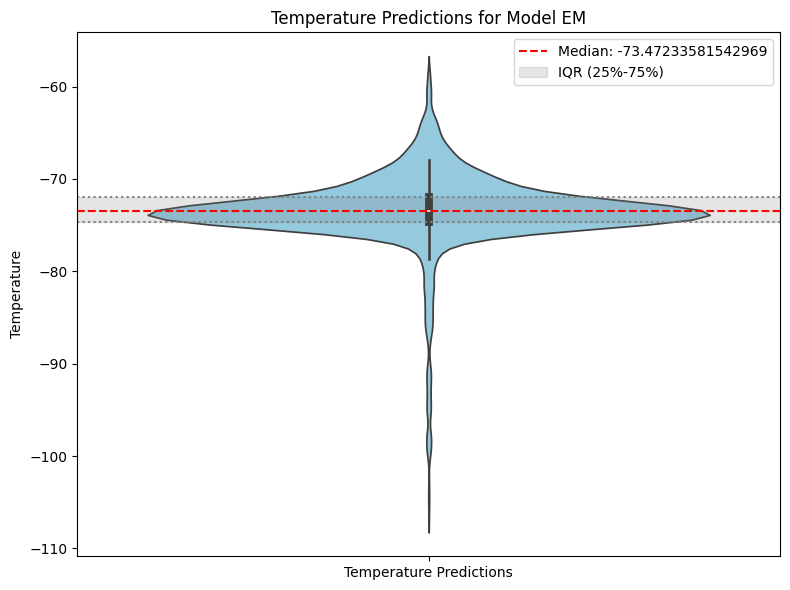

Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -73.415382
std                   4.247916
min                -106.622047
25%                 -74.632456
50%                 -73.472336
75%                 -71.940792
max                 -58.346249
Median of Temperature Predictions: -73.472336



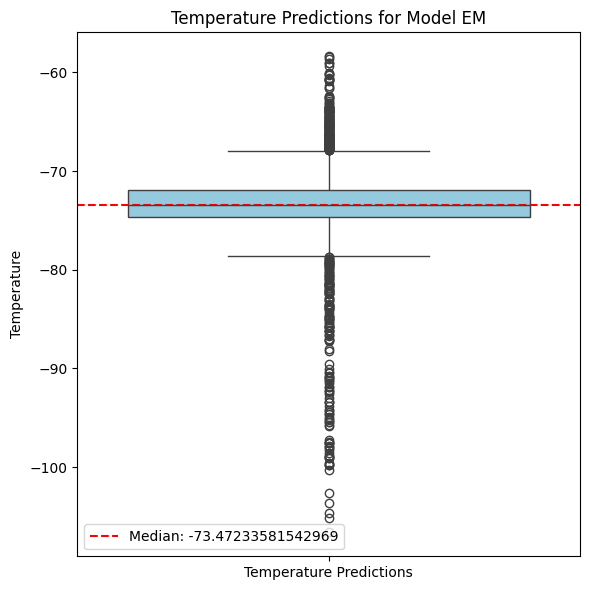

In [304]:
plot_violin_temperature_predictions('EM', BFT_EM)
plot_boxplot_temperature_predictions('EM', BFT_EM)

### FM3

In [280]:
BFT_FM3, EEF_FM3 = predecir_modelo('FM3', model_a, model_b, data_splits_by_model)

116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -77.337868
std                   4.062767
min                -110.010864
25%                 -78.589682
50%                 -77.160995
75%                 -75.591904
max                 -65.726158
Median of Temperature Predictions: -77.160995
Uncertainty (25% - Median): 1.428688
Uncertainty (Median - 75%): 1.5690918



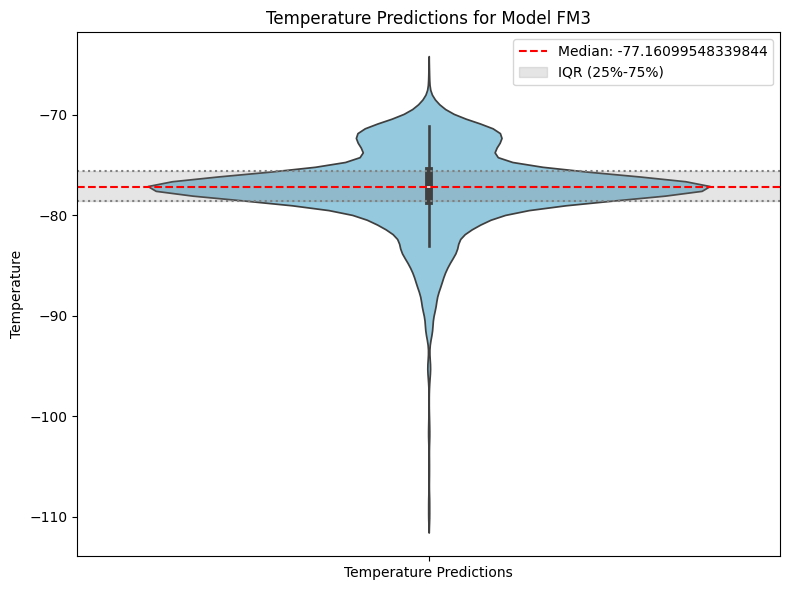

Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -77.337868
std                   4.062767
min                -110.010864
25%                 -78.589682
50%                 -77.160995
75%                 -75.591904
max                 -65.726158
Median of Temperature Predictions: -77.160995



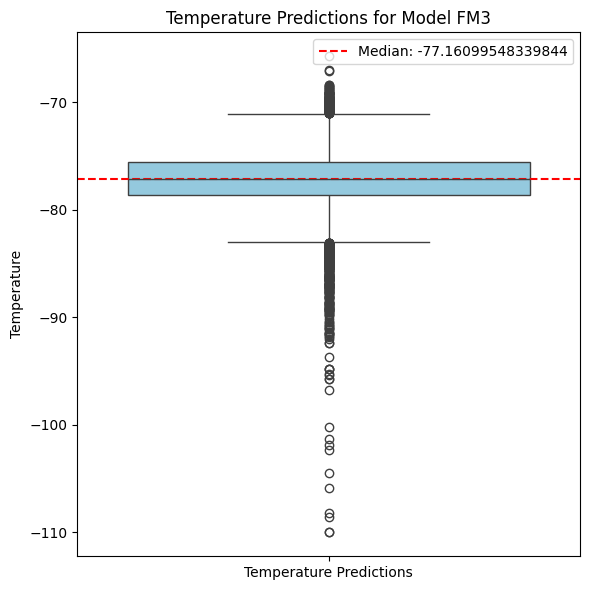

In [305]:
plot_violin_temperature_predictions('FM3', BFT_FM3)
plot_boxplot_temperature_predictions('FM3', BFT_FM3)

### FM6

In [284]:
BFT_FM6, EEF_FM6 = predecir_modelo('FM6', model_a, model_b, data_splits_by_model)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step


Temperature Predictions Statistics:
       Temperature Predictions
count              2952.000000
mean                -83.044693
std                   8.985506
min                -167.139191
25%                 -84.509808
50%                 -80.025150
75%                 -78.000551
max                 -70.015480
Median of Temperature Predictions: -80.02515
Uncertainty (25% - Median): 4.484665
Uncertainty (Median - 75%): 2.0245972



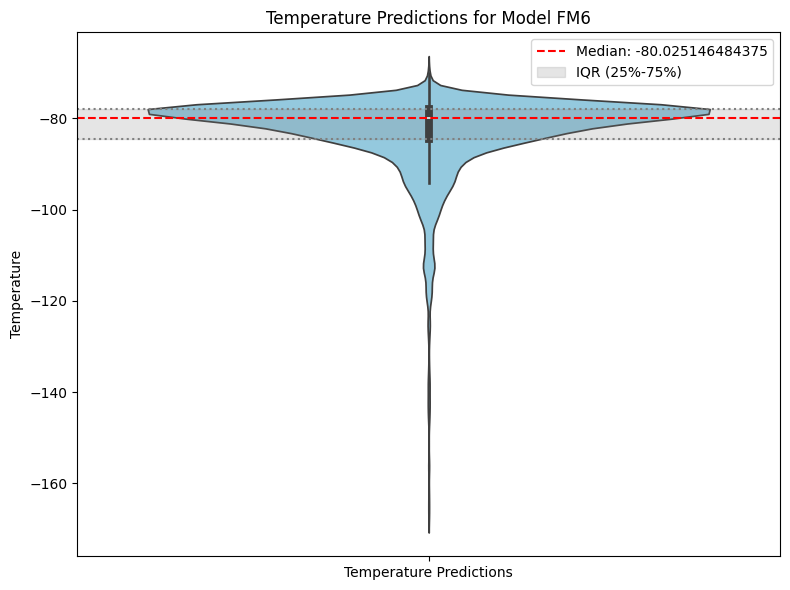

Temperature Predictions Statistics:
       Temperature Predictions
count              2952.000000
mean                -83.044693
std                   8.985506
min                -167.139191
25%                 -84.509808
50%                 -80.025150
75%                 -78.000551
max                 -70.015480
Median of Temperature Predictions: -80.02515



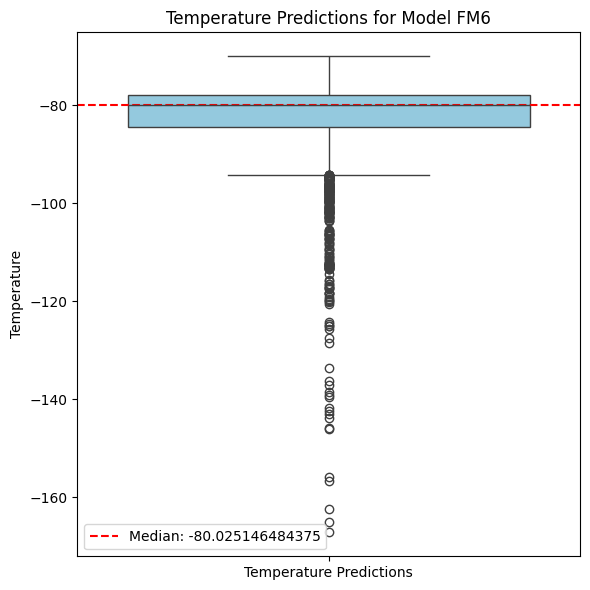

In [306]:
plot_violin_temperature_predictions('FM6', BFT_FM6)
plot_boxplot_temperature_predictions('FM6', BFT_FM6)

### FM10

In [286]:
BFT_FM10, EEF_FM10 = predecir_modelo('FM10', model_a, model_b, data_splits_by_model)

116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step


Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -87.926964
std                  13.086748
min                -171.126846
25%                 -90.089657
50%                 -82.438396
75%                 -80.463518
max                 -73.380272
Median of Temperature Predictions: -82.4384
Uncertainty (25% - Median): 7.6512604
Uncertainty (Median - 75%): 1.974884



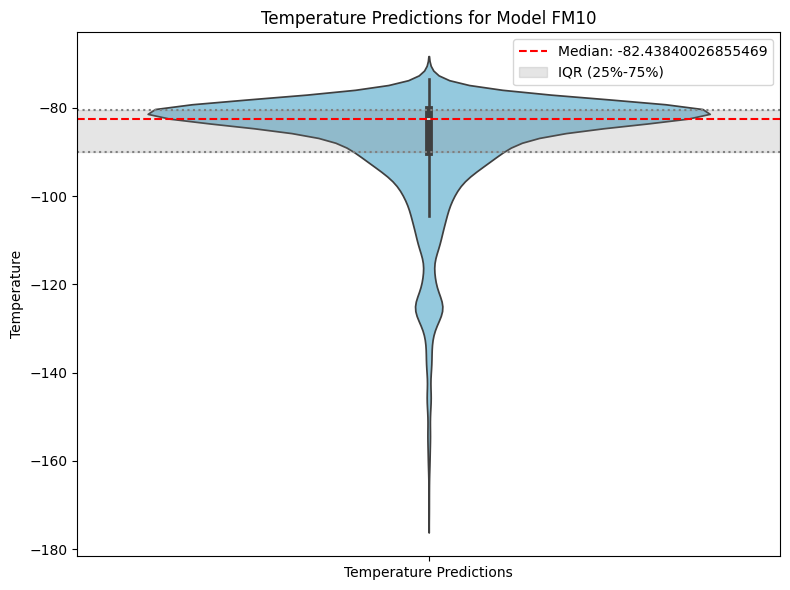

Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -87.926964
std                  13.086748
min                -171.126846
25%                 -90.089657
50%                 -82.438396
75%                 -80.463518
max                 -73.380272
Median of Temperature Predictions: -82.4384



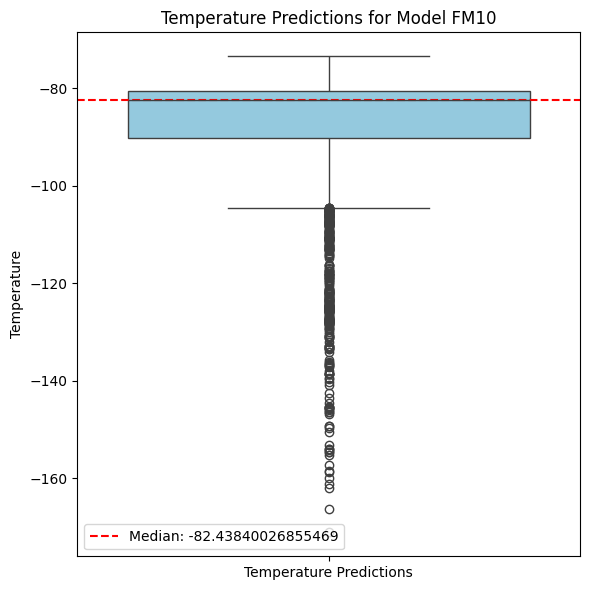

In [307]:
plot_violin_temperature_predictions('FM10', BFT_FM10)
plot_boxplot_temperature_predictions('FM10', BFT_FM10)

### FM16

In [288]:
BFT_FM16, EEF_FM16 = predecir_modelo('FM16', model_a, model_b, data_splits_by_model)

116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step


Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -84.055634
std                   8.049272
min                -147.474426
25%                 -86.261955
50%                 -80.967888
75%                 -79.558437
max                 -71.155106
Median of Temperature Predictions: -80.96789
Uncertainty (25% - Median): 5.2940674
Uncertainty (Median - 75%): 1.4094467



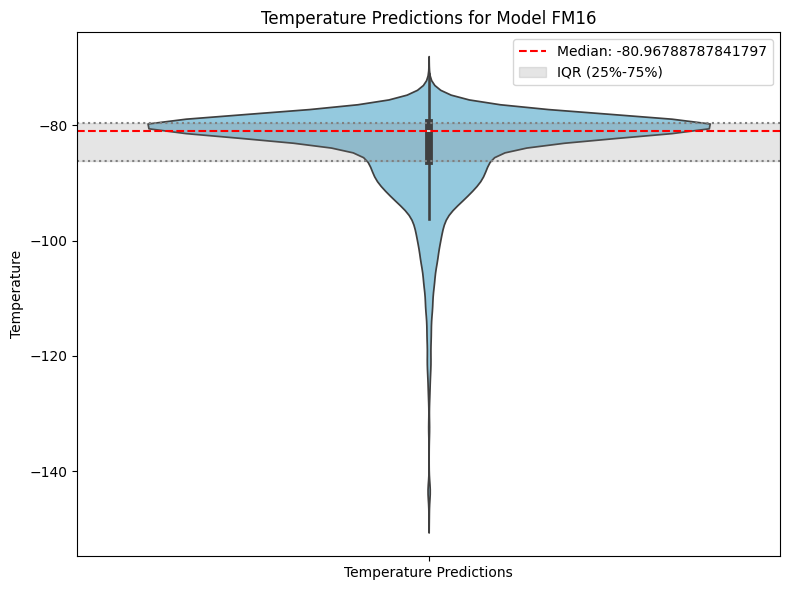

Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -84.055634
std                   8.049272
min                -147.474426
25%                 -86.261955
50%                 -80.967888
75%                 -79.558437
max                 -71.155106
Median of Temperature Predictions: -80.96789



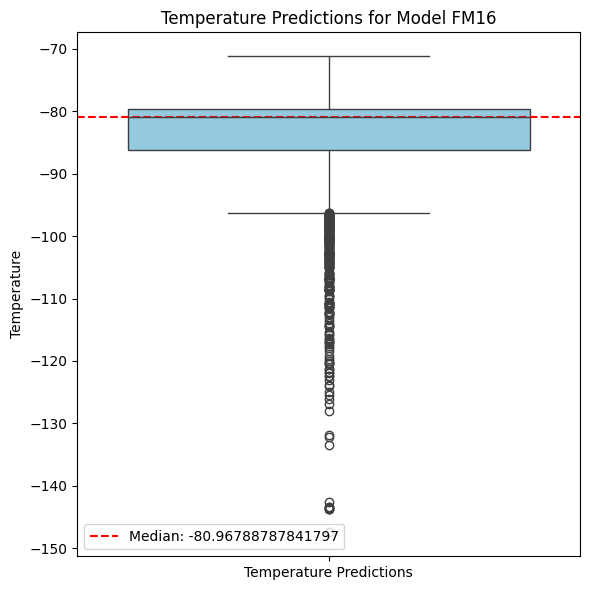

In [308]:
plot_violin_temperature_predictions('FM16', BFT_FM16)
plot_boxplot_temperature_predictions('FM16', BFT_FM16)

### FM20

In [290]:
BFT_FM20, EEF_FM20 = predecir_modelo('FM20', model_a, model_b, data_splits_by_model)

116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step


Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -85.004868
std                   9.626616
min                -151.035355
25%                 -87.403027
50%                 -81.053825
75%                 -79.339996
max                 -71.016167
Median of Temperature Predictions: -81.053825
Uncertainty (25% - Median): 6.349205
Uncertainty (Median - 75%): 1.713829



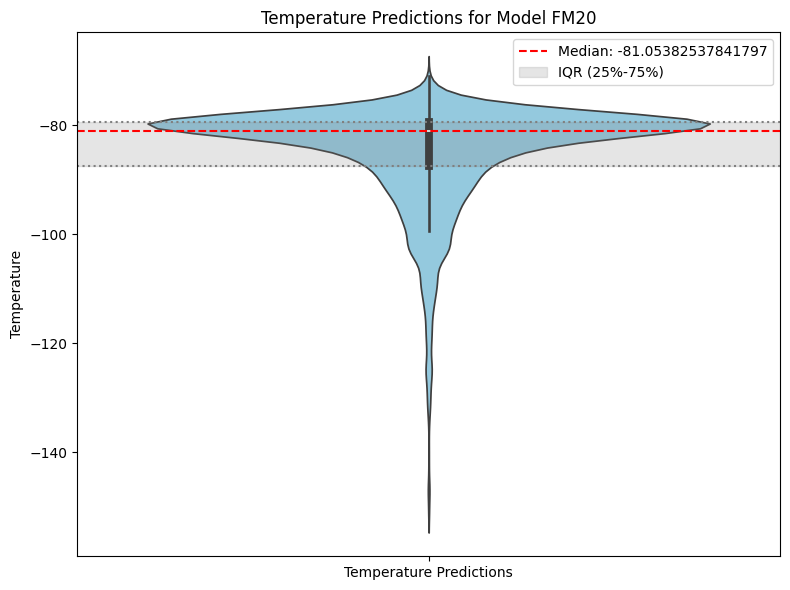

Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -85.004868
std                   9.626616
min                -151.035355
25%                 -87.403027
50%                 -81.053825
75%                 -79.339996
max                 -71.016167
Median of Temperature Predictions: -81.053825



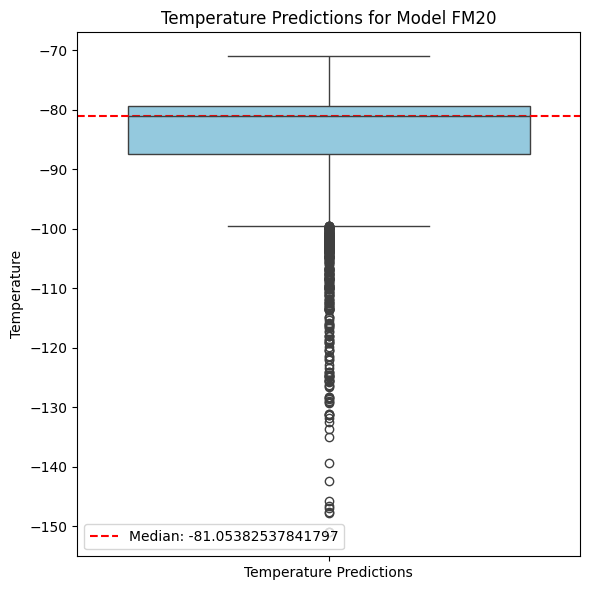

In [309]:
plot_violin_temperature_predictions('FM20', BFT_FM20)
plot_boxplot_temperature_predictions('FM20', BFT_FM20)

### FM22

In [292]:
BFT_FM22, EEF_FM22 = predecir_modelo('FM22', model_a, model_b, data_splits_by_model)

116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -84.788635
std                   8.797062
min                -153.743576
25%                 -87.131762
50%                 -81.064430
75%                 -79.638485
max                 -73.039185
Median of Temperature Predictions: -81.06443
Uncertainty (25% - Median): 6.0673294
Uncertainty (Median - 75%): 1.4259415



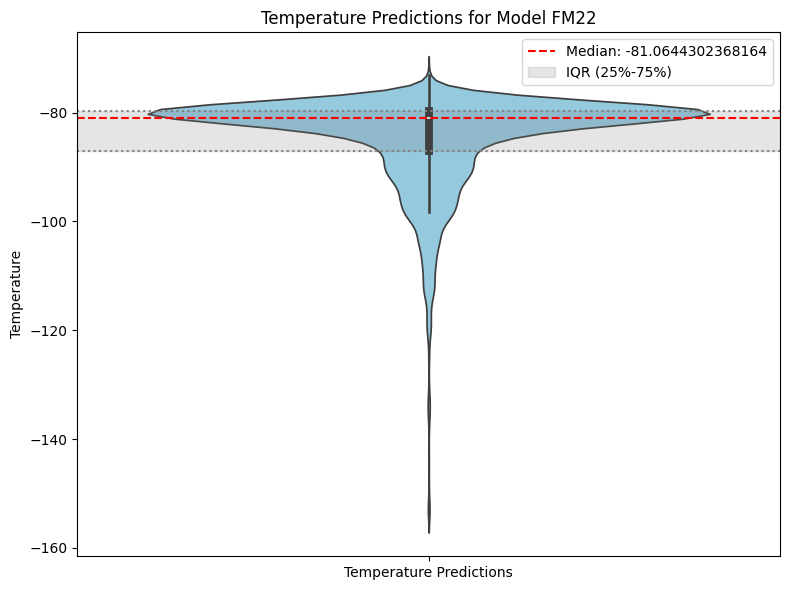

Temperature Predictions Statistics:
       Temperature Predictions
count              3690.000000
mean                -84.788635
std                   8.797062
min                -153.743576
25%                 -87.131762
50%                 -81.064430
75%                 -79.638485
max                 -73.039185
Median of Temperature Predictions: -81.06443



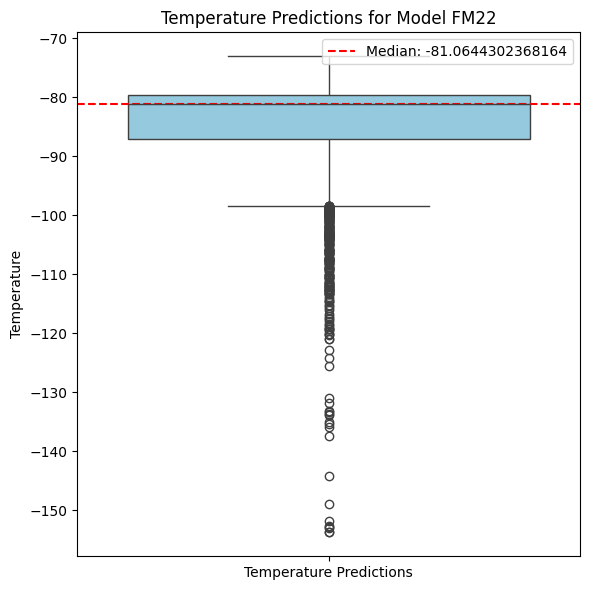

In [310]:
plot_violin_temperature_predictions('FM22', BFT_FM22)
plot_boxplot_temperature_predictions('FM22', BFT_FM22)

### Compare models

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def plot_violin_temperature_predictions_with_global_stats(models, predictions_dict, print_stats=True):
    """
    Plot violin plots for temperature predictions of multiple models and overlay global statistics.

    Args:
        models (list): List of model names (e.g., ['EM', 'FM3', 'FM6', ...]).
        predictions_dict (dict): Dictionary where keys are model names and values are numpy arrays of temperature predictions.
        print_stats (bool): Whether to print the statistics for each model. Default is True.

    Returns:
        dict: A dictionary containing the median and IQR for each model, as well as global statistics.
    """
    # Combine predictions into a single DataFrame for plotting
    data = []
    stats = {}
    all_predictions = []  # To calculate global statistics
    for model in models:
        if model in predictions_dict:
            predictions = predictions_dict[model].flatten()  # Ensure predictions are 1D
            data.extend([(model, pred) for pred in predictions])
            all_predictions.extend(predictions)
            
            # Calculate statistics for each model
            median = np.median(predictions)
            q1 = np.percentile(predictions, 25)
            q3 = np.percentile(predictions, 75)
            iqr = q3 - q1
            stats[model] = {'Median': median, 'IQR': iqr}
        else:
            print(f"Warning: No predictions found for model {model}")

    # Calculate global statistics
    global_median = np.median(all_predictions)
    global_q1 = np.percentile(all_predictions, 25)
    global_q3 = np.percentile(all_predictions, 75)
    global_iqr = global_q3 - global_q1

    stats['Global'] = {'Median': global_median, 'IQR': global_iqr}

    df = pd.DataFrame(data, columns=['Model', 'Temperature Predictions'])

    # Create the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Model', y='Temperature Predictions', data=df, palette='muted')

    # Overlay global statistics
    plt.axhline(global_median, color='red', linestyle='--', label=f'Global Median: {global_median:.2f}')
    plt.axhspan(global_q1, global_q3, color='gray', alpha=0.2, label=f'Global IQR: {global_iqr:.2f}')

    # Add labels and title
    plt.title('Temperature Predictions by Model')
    plt.xlabel('Model')
    plt.ylabel('Temperature Predictions')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print statistics if requested
    if print_stats:
        print("\nStatistics for each model:")
        for model, stat in stats.items():
            print(f"Model {model}: Median = {stat['Median']}, IQR = {stat['IQR']}")

C:\Users\UX450FDX\AppData\Local\Temp\ipykernel_24324\3992477575.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Model', y='Temperature Predictions', data=df, palette='muted')


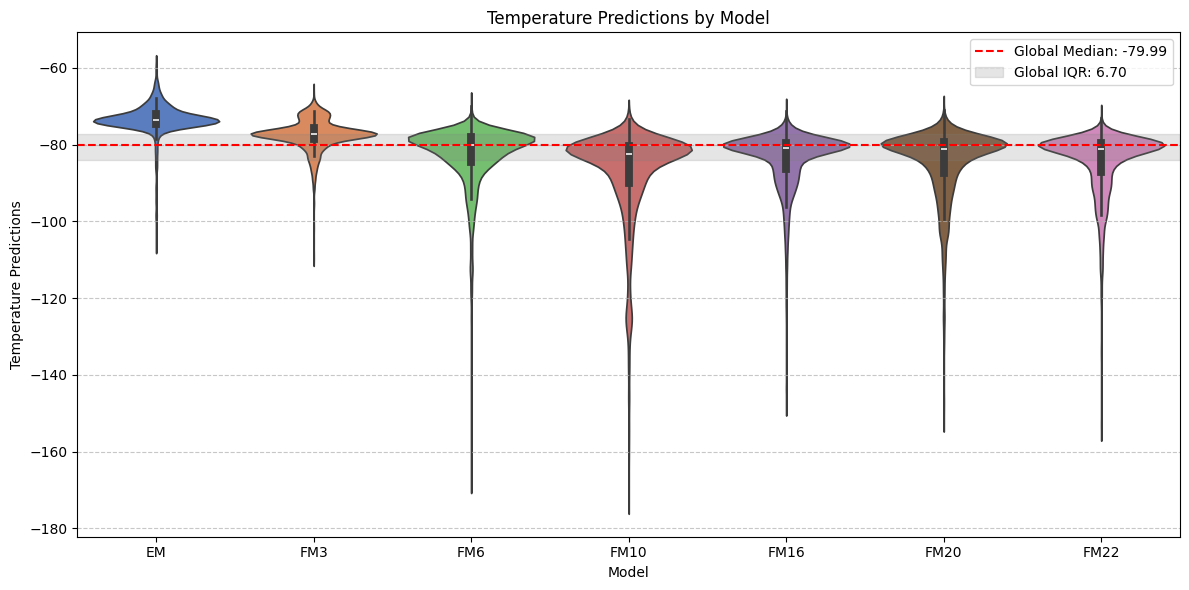


Statistics for each model:
Model EM: Median = -73.47233581542969, IQR = 2.6916580200195312
Model FM3: Median = -77.16099548339844, IQR = 2.9977798461914062
Model FM6: Median = -80.025146484375, IQR = 6.5092620849609375
Model FM10: Median = -82.43840026855469, IQR = 9.626144409179688
Model FM16: Median = -80.96788787841797, IQR = 6.703514099121094
Model FM20: Median = -81.05382537841797, IQR = 8.063034057617188
Model FM22: Median = -81.0644302368164, IQR = 7.4932708740234375
Model Global: Median = -79.98977661132812, IQR = 6.700187683105469


In [325]:
# Supongamos que tienes las predicciones de temperatura para cada modelo en un diccionario
predictions_dict = {
    'EM': BFT_EM,
    'FM3': BFT_FM3,
    'FM6': BFT_FM6,
    'FM10': BFT_FM10,
    'FM16': BFT_FM16,
    'FM20': BFT_FM20,
    'FM22': BFT_FM22
}

# Lista de modelos
models = ['EM', 'FM3', 'FM6', 'FM10', 'FM16', 'FM20', 'FM22']

# Llamar a la función para graficar
plot_violin_temperature_predictions_with_global_stats(models, predictions_dict)